In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *
from models import *

In [3]:
pin_file = "../Data/pin.csv"

pin = read_pin(pin_file)

In [4]:
filename = "../Data/rssi4.csv"
B1 = "0117C55D14E4"

data = read_data(filename, B1)

All beacons: ['0117C55D14E4']
Selecting 0117C55D14E4


In [5]:
data[scanners] = minMaxScaling(data[scanners])

In [6]:
data_grouped = data.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()

## Train Validation Test Split

In [7]:
train, validation, test = train_validation_test_split(data_grouped)

In [8]:
train.groupby("location")[scanners].count()

,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
location,,,,,,,,,,,,,,,,,
V1_11,37,46,38,48,49,47,41,49,45,31,38,52,51,19,18,19,43
V1_12,53,43,36,56,53,52,35,37,64,38,43,65,64,41,53,40,44
V1_13,39,55,37,50,31,44,48,48,67,11,31,50,48,50,51,13,41
V1_14,27,64,34,42,37,49,62,39,65,9,64,32,49,40,52,41,46
V1_20,61,58,56,53,56,53,45,44,47,25,40,51,67,11,38,19,41
V1_21,44,57,39,48,54,48,58,39,63,18,48,49,43,41,41,37,39
V1_22,45,45,38,46,41,64,67,24,64,24,66,43,36,7,53,51,32
V1_23,40,47,42,37,26,73,63,34,76,23,64,43,48,7,59,55,31
V1_24,16,37,39,34,30,47,47,31,64,15,56,33,42,16,36,51,17


In [9]:
validation.shape

(344, 19)

In [10]:
test.shape

(344, 19)

In [11]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

## Imputation
1. Forward fill
2. Fill NaN

In [12]:
train_imputed = train.set_index("location").groupby("location").ffill()
train_imputed.fillna(0, inplace=True)
train_imputed.reset_index(inplace=True)

In [13]:
validation_imputed = validation.set_index("location").groupby("location").ffill()
validation_imputed.fillna(0, inplace=True)
validation_imputed.reset_index(inplace=True)

In [14]:
test_imputed = test.set_index("location").groupby("location").ffill()
test_imputed.fillna(0, inplace=True)
test_imputed.reset_index(inplace=True)

## Change Location to Coordinates

In [15]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [16]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [17]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

## Model Training

In [18]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [19]:
model = MLPRegressor(size='small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, X_validation, y_validation)

Train on 1030 samples, validate on 344 samples
Epoch 1/1000
1030/1030 [==============================] - 1s 722us/sample - loss: 280.0849 - mae: 14.8630 - mse: 280.0171 - val_loss: 264.9707 - val_mae: 14.4726 - val_mse: 264.8933
Epoch 2/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 257.1180 - mae: 14.2196 - mse: 257.0156 - val_loss: 242.3667 - val_mae: 13.7810 - val_mse: 242.2291
Epoch 3/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 232.4387 - mae: 13.4139 - mse: 232.2400 - val_loss: 216.6706 - val_mae: 12.8802 - val_mse: 216.3966
Epoch 4/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 204.7547 - mae: 12.3971 - mse: 204.3599 - val_loss: 188.3053 - val_mae: 11.7854 - val_mse: 187.7759
Epoch 5/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 174.9469 - mae: 11.1894 - mse: 174.2099 - val_loss: 158.4493 - val_mae: 10.4908 - val_mse: 157.4909
Epoch 6/1000
1030/1030 [=======================

1030/1030 [==============================] - 0s 35us/sample - loss: 14.8893 - mae: 1.6983 - mse: 4.2516 - val_loss: 15.9447 - val_mae: 1.7929 - val_mse: 5.7342
Epoch 48/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 14.8024 - mae: 1.6715 - mse: 4.1629 - val_loss: 15.7913 - val_mae: 1.7655 - val_mse: 5.5044
Epoch 49/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 14.7076 - mae: 1.6480 - mse: 4.0429 - val_loss: 15.6529 - val_mae: 1.7278 - val_mse: 5.2859
Epoch 50/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 14.6138 - mae: 1.6292 - mse: 3.9434 - val_loss: 15.5641 - val_mae: 1.6743 - val_mse: 5.1121
Epoch 51/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 14.5181 - mae: 1.6056 - mse: 3.8615 - val_loss: 15.4384 - val_mae: 1.6437 - val_mse: 4.9097
Epoch 52/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 14.4375 - mae: 1.5791 - mse: 3.7419 - val_loss: 15.3883 - val_

1030/1030 [==============================] - 0s 35us/sample - loss: 13.3131 - mae: 1.2316 - mse: 2.4401 - val_loss: 13.8634 - val_mae: 1.3033 - val_mse: 3.2038
Epoch 95/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 13.3050 - mae: 1.2315 - mse: 2.4406 - val_loss: 13.9875 - val_mae: 1.4192 - val_mse: 3.6278
Epoch 96/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 13.3009 - mae: 1.2404 - mse: 2.4733 - val_loss: 13.8337 - val_mae: 1.3299 - val_mse: 3.2834
Epoch 97/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 13.2849 - mae: 1.2248 - mse: 2.4171 - val_loss: 13.9031 - val_mae: 1.3960 - val_mse: 3.5174
Epoch 98/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 13.2763 - mae: 1.2283 - mse: 2.4304 - val_loss: 13.8270 - val_mae: 1.3001 - val_mse: 3.1675
Epoch 99/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 13.2649 - mae: 1.2200 - mse: 2.3991 - val_loss: 13.8623 - val_

Epoch 141/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.9821 - mae: 1.1287 - mse: 2.0797 - val_loss: 13.4245 - val_mae: 1.2942 - val_mse: 2.9592
Epoch 142/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.9789 - mae: 1.1345 - mse: 2.1034 - val_loss: 13.4239 - val_mae: 1.2828 - val_mse: 2.9147
Epoch 143/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.9638 - mae: 1.1253 - mse: 2.0754 - val_loss: 13.4453 - val_mae: 1.3145 - val_mse: 3.0216
Epoch 144/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.9683 - mae: 1.1295 - mse: 2.0887 - val_loss: 13.3648 - val_mae: 1.2254 - val_mse: 2.7102
Epoch 145/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.9614 - mae: 1.1259 - mse: 2.0719 - val_loss: 13.3874 - val_mae: 1.1378 - val_mse: 2.4248
Epoch 146/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.9582 - mae: 1.1160 - mse: 2.0369 - val_

Epoch 188/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.8016 - mae: 1.0712 - mse: 1.8968 - val_loss: 13.1638 - val_mae: 1.1827 - val_mse: 2.4926
Epoch 189/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.8077 - mae: 1.0749 - mse: 1.9102 - val_loss: 13.1963 - val_mae: 1.2090 - val_mse: 2.5670
Epoch 190/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.8026 - mae: 1.0725 - mse: 1.8984 - val_loss: 13.1486 - val_mae: 1.1506 - val_mse: 2.3877
Epoch 191/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.8033 - mae: 1.0755 - mse: 1.9143 - val_loss: 13.1499 - val_mae: 1.1327 - val_mse: 2.3318
Epoch 192/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.7988 - mae: 1.0668 - mse: 1.8871 - val_loss: 13.2158 - val_mae: 1.1773 - val_mse: 2.4607
Epoch 193/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.7967 - mae: 1.0607 - mse: 1.8701 - val_

Epoch 235/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7100 - mae: 1.0425 - mse: 1.8072 - val_loss: 13.0895 - val_mae: 1.0854 - val_mse: 2.1602
Epoch 236/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7071 - mae: 1.0283 - mse: 1.7714 - val_loss: 13.0764 - val_mae: 1.1552 - val_mse: 2.3660
Epoch 237/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 12.7055 - mae: 1.0393 - mse: 1.7981 - val_loss: 13.0604 - val_mae: 1.1473 - val_mse: 2.3490
Epoch 238/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.7076 - mae: 1.0410 - mse: 1.8095 - val_loss: 13.0647 - val_mae: 1.0968 - val_mse: 2.1928
Epoch 239/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.7026 - mae: 1.0399 - mse: 1.8035 - val_loss: 13.0704 - val_mae: 1.0797 - val_mse: 2.1486
Epoch 240/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.7036 - mae: 1.0335 - mse: 1.7798 - val_

1030/1030 [==============================] - 0s 38us/sample - loss: 12.6430 - mae: 1.0229 - mse: 1.7552 - val_loss: 13.0166 - val_mae: 1.1095 - val_mse: 2.2176
Epoch 282/1000
1030/1030 [==============================] - 0s 37us/sample - loss: 12.6415 - mae: 1.0214 - mse: 1.7501 - val_loss: 13.0502 - val_mae: 1.1481 - val_mse: 2.3291
Epoch 283/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.6407 - mae: 1.0201 - mse: 1.7446 - val_loss: 13.0176 - val_mae: 1.1792 - val_mse: 2.4479
Epoch 284/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.6435 - mae: 1.0273 - mse: 1.7719 - val_loss: 13.0419 - val_mae: 1.1204 - val_mse: 2.2424
Epoch 285/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.6390 - mae: 1.0252 - mse: 1.7593 - val_loss: 13.0386 - val_mae: 1.1151 - val_mse: 2.2299
Epoch 286/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.6372 - mae: 1.0186 - mse: 1.7424 - val_loss: 13.0160 -

Epoch 328/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.5941 - mae: 1.0128 - mse: 1.7271 - val_loss: 13.0212 - val_mae: 1.0820 - val_mse: 2.1308
Epoch 329/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.5918 - mae: 1.0064 - mse: 1.7107 - val_loss: 12.9852 - val_mae: 1.1472 - val_mse: 2.3259
Epoch 330/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.5921 - mae: 1.0134 - mse: 1.7230 - val_loss: 12.9665 - val_mae: 1.1022 - val_mse: 2.1918
Epoch 331/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.5901 - mae: 1.0083 - mse: 1.7111 - val_loss: 12.9936 - val_mae: 1.0594 - val_mse: 2.0670
Epoch 332/1000
1030/1030 [==============================] - 0s 37us/sample - loss: 12.5850 - mae: 0.9998 - mse: 1.6893 - val_loss: 13.0108 - val_mae: 1.2173 - val_mse: 2.5479
Epoch 333/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.5925 - mae: 1.0190 - mse: 1.7470 - val_

Epoch 375/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5501 - mae: 1.0096 - mse: 1.7180 - val_loss: 12.9582 - val_mae: 1.1069 - val_mse: 2.2031
Epoch 376/1000
1030/1030 [==============================] - 0s 37us/sample - loss: 12.5486 - mae: 0.9988 - mse: 1.6822 - val_loss: 12.9718 - val_mae: 1.1112 - val_mse: 2.2117
Epoch 377/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5442 - mae: 0.9988 - mse: 1.6832 - val_loss: 12.9446 - val_mae: 1.1117 - val_mse: 2.2218
Epoch 378/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5416 - mae: 1.0008 - mse: 1.6894 - val_loss: 12.9825 - val_mae: 1.0887 - val_mse: 2.1448
Epoch 379/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5462 - mae: 0.9971 - mse: 1.6808 - val_loss: 12.9479 - val_mae: 1.0593 - val_mse: 2.0717
Epoch 380/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.5489 - mae: 0.9958 - mse: 1.6810 - val_

Epoch 422/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5041 - mae: 0.9850 - mse: 1.6441 - val_loss: 12.9699 - val_mae: 1.1538 - val_mse: 2.3279
Epoch 423/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5092 - mae: 0.9911 - mse: 1.6646 - val_loss: 12.9438 - val_mae: 1.0664 - val_mse: 2.0846
Epoch 424/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5044 - mae: 0.9860 - mse: 1.6439 - val_loss: 12.9177 - val_mae: 1.0601 - val_mse: 2.0738
Epoch 425/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5079 - mae: 0.9888 - mse: 1.6597 - val_loss: 12.9668 - val_mae: 1.1516 - val_mse: 2.3216
Epoch 426/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5067 - mae: 0.9922 - mse: 1.6632 - val_loss: 12.9354 - val_mae: 1.0546 - val_mse: 2.0528
Epoch 427/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5071 - mae: 0.9847 - mse: 1.6477 - val_

Epoch 469/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.4731 - mae: 0.9822 - mse: 1.6408 - val_loss: 12.9217 - val_mae: 1.0803 - val_mse: 2.1141
Epoch 470/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4758 - mae: 0.9827 - mse: 1.6407 - val_loss: 12.9868 - val_mae: 0.9908 - val_mse: 1.8868
Epoch 471/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.4806 - mae: 0.9663 - mse: 1.5970 - val_loss: 12.9095 - val_mae: 1.0568 - val_mse: 2.0546
Epoch 472/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4751 - mae: 0.9842 - mse: 1.6416 - val_loss: 12.9443 - val_mae: 1.0300 - val_mse: 1.9796
Epoch 473/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.4728 - mae: 0.9716 - mse: 1.6149 - val_loss: 12.9191 - val_mae: 1.1022 - val_mse: 2.1727
Epoch 474/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.4757 - mae: 0.9822 - mse: 1.6383 - val_

Epoch 516/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4414 - mae: 0.9730 - mse: 1.6135 - val_loss: 12.8691 - val_mae: 1.1300 - val_mse: 2.2699
Epoch 517/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4403 - mae: 0.9831 - mse: 1.6363 - val_loss: 13.0245 - val_mae: 0.9872 - val_mse: 1.8594
Epoch 518/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4458 - mae: 0.9543 - mse: 1.5518 - val_loss: 12.8488 - val_mae: 1.1053 - val_mse: 2.2139
Epoch 519/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.4427 - mae: 0.9771 - mse: 1.6164 - val_loss: 12.8746 - val_mae: 1.0703 - val_mse: 2.0934
Epoch 520/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4400 - mae: 0.9703 - mse: 1.6103 - val_loss: 12.8584 - val_mae: 1.1336 - val_mse: 2.2991
Epoch 521/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4407 - mae: 0.9813 - mse: 1.6379 - val_

Epoch 563/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4224 - mae: 0.9507 - mse: 1.5457 - val_loss: 12.8619 - val_mae: 1.1291 - val_mse: 2.2547
Epoch 564/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4229 - mae: 0.9694 - mse: 1.6040 - val_loss: 12.8478 - val_mae: 1.0877 - val_mse: 2.1365
Epoch 565/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 12.4153 - mae: 0.9680 - mse: 1.5943 - val_loss: 12.8454 - val_mae: 1.0968 - val_mse: 2.1716
Epoch 566/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.4169 - mae: 0.9704 - mse: 1.6034 - val_loss: 12.8643 - val_mae: 1.1245 - val_mse: 2.2396
Epoch 567/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.4127 - mae: 0.9707 - mse: 1.5990 - val_loss: 12.8502 - val_mae: 1.0881 - val_mse: 2.1394
Epoch 568/1000
1030/1030 [==============================] - 0s 36us/sample - loss: 12.4181 - mae: 0.9679 - mse: 1.5928 - val_

Epoch 610/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3938 - mae: 0.9580 - mse: 1.5626 - val_loss: 12.8983 - val_mae: 1.0324 - val_mse: 1.9737
Epoch 611/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.3932 - mae: 0.9510 - mse: 1.5435 - val_loss: 12.8210 - val_mae: 1.1213 - val_mse: 2.2537
Epoch 612/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3937 - mae: 0.9649 - mse: 1.5878 - val_loss: 12.8611 - val_mae: 1.0175 - val_mse: 1.9514
Epoch 613/1000
1030/1030 [==============================] - 0s 72us/sample - loss: 12.3923 - mae: 0.9553 - mse: 1.5608 - val_loss: 12.8602 - val_mae: 1.0580 - val_mse: 2.0468
Epoch 614/1000
1030/1030 [==============================] - 0s 56us/sample - loss: 12.3898 - mae: 0.9559 - mse: 1.5525 - val_loss: 12.8547 - val_mae: 1.1847 - val_mse: 2.4384
Epoch 615/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 12.3945 - mae: 0.9747 - mse: 1.6182 - val_

Epoch 657/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3733 - mae: 0.9557 - mse: 1.5569 - val_loss: 12.8397 - val_mae: 1.0339 - val_mse: 1.9886
Epoch 658/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3716 - mae: 0.9514 - mse: 1.5468 - val_loss: 12.8464 - val_mae: 1.0087 - val_mse: 1.9283
Epoch 659/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3665 - mae: 0.9491 - mse: 1.5368 - val_loss: 12.8405 - val_mae: 1.1741 - val_mse: 2.4004
Epoch 660/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3690 - mae: 0.9644 - mse: 1.5914 - val_loss: 12.8469 - val_mae: 1.0026 - val_mse: 1.9150
Epoch 661/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3662 - mae: 0.9487 - mse: 1.5399 - val_loss: 12.8455 - val_mae: 1.0346 - val_mse: 1.9885
Epoch 662/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3660 - mae: 0.9482 - mse: 1.5392 - val_

Epoch 704/1000
1030/1030 [==============================] - 0s 76us/sample - loss: 12.3503 - mae: 0.9565 - mse: 1.5607 - val_loss: 12.8238 - val_mae: 1.0312 - val_mse: 1.9777
Epoch 705/1000
1030/1030 [==============================] - 0s 71us/sample - loss: 12.3486 - mae: 0.9466 - mse: 1.5263 - val_loss: 12.8039 - val_mae: 1.0517 - val_mse: 2.0405
Epoch 706/1000
1030/1030 [==============================] - 0s 73us/sample - loss: 12.3503 - mae: 0.9481 - mse: 1.5319 - val_loss: 12.8041 - val_mae: 1.1163 - val_mse: 2.2215
Epoch 707/1000
1030/1030 [==============================] - 0s 62us/sample - loss: 12.3368 - mae: 0.9518 - mse: 1.5473 - val_loss: 12.8777 - val_mae: 1.0100 - val_mse: 1.9144
Epoch 708/1000
1030/1030 [==============================] - 0s 66us/sample - loss: 12.3444 - mae: 0.9427 - mse: 1.5181 - val_loss: 12.8084 - val_mae: 1.0727 - val_mse: 2.0948
Epoch 709/1000
1030/1030 [==============================] - 0s 68us/sample - loss: 12.3520 - mae: 0.9473 - mse: 1.5378 - val_

Epoch 751/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3340 - mae: 0.9524 - mse: 1.5483 - val_loss: 12.7926 - val_mae: 1.0372 - val_mse: 2.0074
Epoch 752/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3322 - mae: 0.9464 - mse: 1.5289 - val_loss: 12.7854 - val_mae: 1.1104 - val_mse: 2.2451
Epoch 753/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3336 - mae: 0.9517 - mse: 1.5537 - val_loss: 12.7779 - val_mae: 1.0434 - val_mse: 2.0356
Epoch 754/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3325 - mae: 0.9487 - mse: 1.5358 - val_loss: 12.8036 - val_mae: 1.0730 - val_mse: 2.0866
Epoch 755/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3312 - mae: 0.9449 - mse: 1.5253 - val_loss: 12.8159 - val_mae: 1.1240 - val_mse: 2.2351
Epoch 756/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3307 - mae: 0.9489 - mse: 1.5373 - val_

Epoch 798/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3163 - mae: 0.9455 - mse: 1.5349 - val_loss: 12.7877 - val_mae: 1.0452 - val_mse: 2.0194
Epoch 799/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3148 - mae: 0.9396 - mse: 1.5121 - val_loss: 12.8035 - val_mae: 1.0559 - val_mse: 2.0406
Epoch 800/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 12.3172 - mae: 0.9419 - mse: 1.5197 - val_loss: 12.7635 - val_mae: 1.0718 - val_mse: 2.1233
Epoch 801/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3132 - mae: 0.9493 - mse: 1.5414 - val_loss: 12.8822 - val_mae: 0.9678 - val_mse: 1.8129
Epoch 802/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3188 - mae: 0.9308 - mse: 1.4868 - val_loss: 12.8001 - val_mae: 1.1498 - val_mse: 2.3243
Epoch 803/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3131 - mae: 0.9511 - mse: 1.5434 - val_

Epoch 845/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 12.3008 - mae: 0.9343 - mse: 1.4955 - val_loss: 12.7929 - val_mae: 1.1526 - val_mse: 2.3227
Epoch 846/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.3001 - mae: 0.9437 - mse: 1.5226 - val_loss: 12.7690 - val_mae: 1.1282 - val_mse: 2.2650
Epoch 847/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.2980 - mae: 0.9429 - mse: 1.5222 - val_loss: 12.7577 - val_mae: 1.1046 - val_mse: 2.1972
Epoch 848/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3013 - mae: 0.9461 - mse: 1.5265 - val_loss: 12.7562 - val_mae: 1.0761 - val_mse: 2.1164
Epoch 849/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.2963 - mae: 0.9428 - mse: 1.5123 - val_loss: 12.7632 - val_mae: 1.0386 - val_mse: 2.0107
Epoch 850/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 12.2985 - mae: 0.9397 - mse: 1.5119 - val_

Epoch 892/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.2842 - mae: 0.9433 - mse: 1.5157 - val_loss: 12.7655 - val_mae: 1.1235 - val_mse: 2.2462
Epoch 893/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.2848 - mae: 0.9485 - mse: 1.5322 - val_loss: 12.7896 - val_mae: 1.0352 - val_mse: 1.9832
Epoch 894/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.2894 - mae: 0.9346 - mse: 1.4950 - val_loss: 12.7945 - val_mae: 1.0689 - val_mse: 2.0709
Epoch 895/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.2852 - mae: 0.9360 - mse: 1.4988 - val_loss: 12.7548 - val_mae: 1.0357 - val_mse: 1.9999
Epoch 896/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.2805 - mae: 0.9297 - mse: 1.4757 - val_loss: 12.7933 - val_mae: 1.1804 - val_mse: 2.4244
Epoch 897/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2891 - mae: 0.9477 - mse: 1.5385 - val_

Epoch 939/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2755 - mae: 0.9404 - mse: 1.5156 - val_loss: 12.7601 - val_mae: 1.0053 - val_mse: 1.9253
Epoch 940/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2756 - mae: 0.9306 - mse: 1.4849 - val_loss: 12.7563 - val_mae: 1.1081 - val_mse: 2.2004
Epoch 941/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2663 - mae: 0.9352 - mse: 1.4890 - val_loss: 12.7564 - val_mae: 1.1160 - val_mse: 2.2310
Epoch 942/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.2755 - mae: 0.9420 - mse: 1.5112 - val_loss: 12.7458 - val_mae: 1.0886 - val_mse: 2.1441
Epoch 943/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2716 - mae: 0.9363 - mse: 1.4972 - val_loss: 12.7702 - val_mae: 1.1555 - val_mse: 2.3463
Epoch 944/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2692 - mae: 0.9494 - mse: 1.5308 - val_

Epoch 986/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2593 - mae: 0.9446 - mse: 1.5178 - val_loss: 12.7742 - val_mae: 1.0042 - val_mse: 1.9086
Epoch 987/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2611 - mae: 0.9296 - mse: 1.4836 - val_loss: 12.7426 - val_mae: 1.0147 - val_mse: 1.9546
Epoch 988/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.2588 - mae: 0.9320 - mse: 1.4811 - val_loss: 12.7498 - val_mae: 1.1211 - val_mse: 2.2329
Epoch 989/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2588 - mae: 0.9347 - mse: 1.4885 - val_loss: 12.7942 - val_mae: 1.1395 - val_mse: 2.2745
Epoch 990/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2641 - mae: 0.9429 - mse: 1.5128 - val_loss: 12.7456 - val_mae: 1.0121 - val_mse: 1.9350
Epoch 991/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.2622 - mae: 0.9313 - mse: 1.4857 - val_

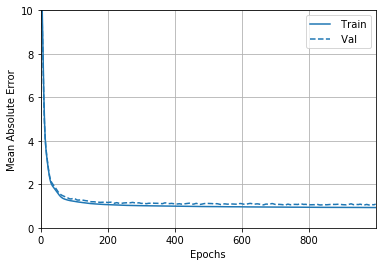

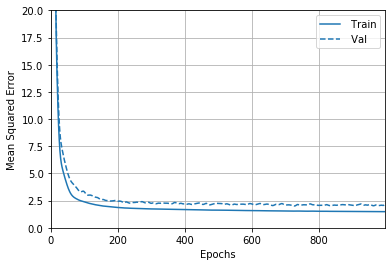

In [21]:
model.show_history()

## Model Validation

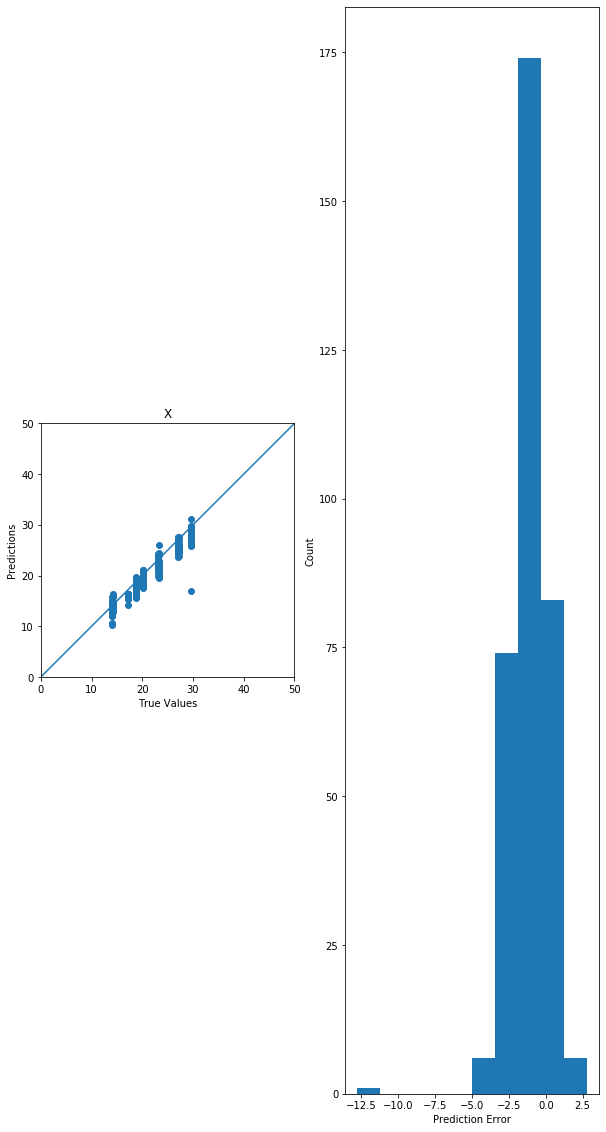

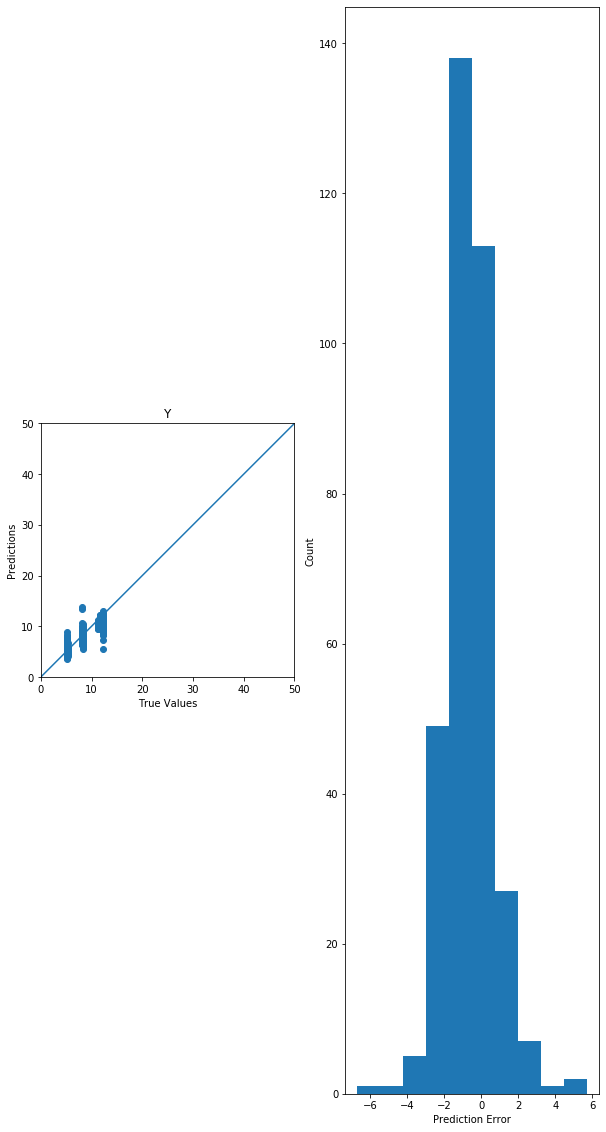

In [22]:
model.model_validation(X_validation, y_validation)

## Model Testing

In [23]:
model.model_testing(X_test, y_test)

344/1 - 0s - loss: 10.8314 - mae: 1.2104 - mse: 2.3216
Test loss: 12.964543852695199
Mean absolute error: 1.2103634
Mean squared error: 2.3215694


## Plotting Learning Curves

In [24]:
train_loss = []
val_loss = []

for f in range(1, 11, 1):
    frac = f / 10.0
    sample = data_grouped.sample(frac=frac, random_state=12345)
    sample_grouped = sample.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()
    train, validation, test = train_validation_test_split(sample_grouped)

    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    train_imputed = train.set_index("location").groupby("location").ffill()
    train_imputed.fillna(0, inplace=True)
    train_imputed.reset_index(inplace=True)

    validation_imputed = validation.set_index("location").groupby("location").ffill()
    validation_imputed.fillna(0, inplace=True)
    validation_imputed.reset_index(inplace=True)

    test_imputed = test.set_index("location").groupby("location").ffill()
    test_imputed.fillna(0, inplace=True)
    test_imputed.reset_index(inplace=True)

    train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
    train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

    validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
    validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

    test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
    test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

    X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
    X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

    model = MLPRegressor()
    history = model.fit(X_train, y_train, X_validation, y_validation)
    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 103 samples, validate on 34 samples
Epoch 1/1000
103/103 [==============================] - 0s 5ms/sample - loss: 276.3060 - mae: 14.7321 - mse: 276.2212 - val_loss: 275.2405 - val_mae: 14.7711 - val_mse: 275.1510
Epoch 2/1000
103/103 [==============================] - 0s 118us/sample - loss: 263.9309 - mae: 14.3518 - mse: 263.8362 - val_loss: 265.0999 - val_mae: 14.4681

Epoch 43/1000
103/103 [==============================] - 0s 121us/sample - loss: 19.3525 - mae: 2.4828 - mse: 9.2577 - val_loss: 23.6833 - val_mae: 2.9807 - val_mse: 14.8943
Epoch 44/1000
103/103 [==============================] - 0s 117us/sample - loss: 19.0059 - mae: 2.4449 - mse: 9.2801 - val_loss: 22.3885 - val_mae: 2.8599 - val_mse: 13.0299
Epoch 45/1000
103/103 [==============================] - 0s 117us/sample - loss: 18.4917 - mae: 2.3713 - mse: 8.4480 - val_loss: 22.8598 - val_mae: 2.8828 - val_mse: 14.1220
Epoch 46/1000
103/103 [==============================] - 0s 114us/sample - loss: 18.3469 - mae: 2.3714 - mse: 8.7748 - val_loss: 21.4942 - val_mae: 2.7400 - val_mse: 12.0039
Epoch 47/1000
103/103 [==============================] - 0s 117us/sample - loss: 18.0002 - mae: 2.3051 - mse: 7.9300 - val_loss: 21.0658 - val_mae: 2.6797 - val_mse: 11.3863
Epoch 48/1000
103/103 [==============================] - 0s 113us/sample - loss: 17.9749 - mae: 2.2908 - mse: 8.0503 - val_loss: 2

103/103 [==============================] - 0s 115us/sample - loss: 15.1280 - mae: 1.8370 - mse: 5.3403 - val_loss: 17.7119 - val_mae: 2.0672 - val_mse: 7.2665
Epoch 91/1000
103/103 [==============================] - 0s 122us/sample - loss: 14.6820 - mae: 1.6579 - mse: 4.2781 - val_loss: 17.8221 - val_mae: 2.1352 - val_mse: 8.0332
Epoch 92/1000
103/103 [==============================] - 0s 111us/sample - loss: 14.6921 - mae: 1.7050 - mse: 4.4767 - val_loss: 18.7334 - val_mae: 2.3822 - val_mse: 9.6046
Epoch 93/1000
103/103 [==============================] - 0s 112us/sample - loss: 14.9344 - mae: 1.7957 - mse: 5.1167 - val_loss: 17.5972 - val_mae: 2.0647 - val_mse: 7.3698
Epoch 94/1000
103/103 [==============================] - 0s 111us/sample - loss: 14.5803 - mae: 1.6528 - mse: 4.2848 - val_loss: 17.6033 - val_mae: 2.0493 - val_mse: 6.9162
Epoch 95/1000
103/103 [==============================] - 0s 113us/sample - loss: 14.5392 - mae: 1.6270 - mse: 4.1148 - val_loss: 17.5054 - val_mae: 2

103/103 [==============================] - 0s 116us/sample - loss: 13.3383 - mae: 1.3595 - mse: 2.8710 - val_loss: 16.6417 - val_mae: 1.8453 - val_mse: 5.9445
Epoch 138/1000
103/103 [==============================] - 0s 120us/sample - loss: 13.2802 - mae: 1.2998 - mse: 2.7899 - val_loss: 16.6203 - val_mae: 1.9124 - val_mse: 6.5216
Epoch 139/1000
103/103 [==============================] - 0s 114us/sample - loss: 13.1282 - mae: 1.3438 - mse: 2.8917 - val_loss: 16.5861 - val_mae: 1.9270 - val_mse: 6.5534
Epoch 140/1000
103/103 [==============================] - 0s 112us/sample - loss: 13.1302 - mae: 1.3432 - mse: 2.9120 - val_loss: 16.4656 - val_mae: 1.8236 - val_mse: 5.9784
Epoch 141/1000
103/103 [==============================] - 0s 114us/sample - loss: 13.2119 - mae: 1.3329 - mse: 2.8608 - val_loss: 16.4001 - val_mae: 1.8632 - val_mse: 6.1698
Epoch 142/1000
103/103 [==============================] - 0s 112us/sample - loss: 13.0687 - mae: 1.3031 - mse: 2.7929 - val_loss: 16.3292 - val_m

103/103 [==============================] - 0s 121us/sample - loss: 12.5783 - mae: 1.1414 - mse: 2.0720 - val_loss: 16.1132 - val_mae: 1.7099 - val_mse: 5.2541
Epoch 185/1000
103/103 [==============================] - 0s 222us/sample - loss: 12.6358 - mae: 1.1474 - mse: 2.1309 - val_loss: 16.1437 - val_mae: 1.7132 - val_mse: 5.1256
Epoch 186/1000
103/103 [==============================] - 0s 247us/sample - loss: 12.4995 - mae: 1.1117 - mse: 2.0275 - val_loss: 16.1509 - val_mae: 1.7061 - val_mse: 5.0805
Epoch 187/1000
103/103 [==============================] - 0s 254us/sample - loss: 12.5903 - mae: 1.1319 - mse: 2.0852 - val_loss: 16.1193 - val_mae: 1.8663 - val_mse: 6.0274
Epoch 188/1000
103/103 [==============================] - 0s 286us/sample - loss: 12.5092 - mae: 1.1930 - mse: 2.2774 - val_loss: 16.0889 - val_mae: 1.8467 - val_mse: 5.9383
Epoch 189/1000
103/103 [==============================] - 0s 259us/sample - loss: 12.5223 - mae: 1.1967 - mse: 2.2696 - val_loss: 16.5546 - val_m

103/103 [==============================] - 0s 224us/sample - loss: 12.3833 - mae: 1.1946 - mse: 2.2791 - val_loss: 15.8895 - val_mae: 1.7732 - val_mse: 5.3442
Epoch 232/1000
103/103 [==============================] - 0s 242us/sample - loss: 12.2070 - mae: 1.0807 - mse: 1.8980 - val_loss: 16.2258 - val_mae: 1.6977 - val_mse: 4.9901
Epoch 233/1000
103/103 [==============================] - 0s 217us/sample - loss: 12.2478 - mae: 1.0256 - mse: 1.7129 - val_loss: 15.8977 - val_mae: 1.7555 - val_mse: 5.2022
Epoch 234/1000
103/103 [==============================] - 0s 242us/sample - loss: 12.2333 - mae: 1.0610 - mse: 1.8102 - val_loss: 16.2418 - val_mae: 1.7795 - val_mse: 5.1463
Epoch 235/1000
103/103 [==============================] - 0s 180us/sample - loss: 12.2735 - mae: 1.0620 - mse: 1.8605 - val_loss: 15.9559 - val_mae: 1.7256 - val_mse: 5.0660
Epoch 236/1000
103/103 [==============================] - 0s 115us/sample - loss: 12.2338 - mae: 1.0614 - mse: 1.7867 - val_loss: 16.7685 - val_m

103/103 [==============================] - 0s 124us/sample - loss: 12.0686 - mae: 0.9750 - mse: 1.5387 - val_loss: 15.9800 - val_mae: 1.8204 - val_mse: 5.5148
Epoch 279/1000
103/103 [==============================] - 0s 116us/sample - loss: 12.1332 - mae: 1.0284 - mse: 1.7977 - val_loss: 16.8896 - val_mae: 1.7554 - val_mse: 5.0529
Epoch 280/1000
103/103 [==============================] - 0s 121us/sample - loss: 12.2575 - mae: 0.9572 - mse: 1.5254 - val_loss: 16.3000 - val_mae: 1.6902 - val_mse: 4.9105
Epoch 281/1000
103/103 [==============================] - 0s 117us/sample - loss: 12.1220 - mae: 0.9807 - mse: 1.5642 - val_loss: 16.3509 - val_mae: 1.7290 - val_mse: 4.9621
Epoch 282/1000
103/103 [==============================] - 0s 119us/sample - loss: 12.1166 - mae: 0.9426 - mse: 1.4485 - val_loss: 16.0236 - val_mae: 1.6945 - val_mse: 5.0987
Epoch 283/1000
103/103 [==============================] - 0s 121us/sample - loss: 12.0765 - mae: 1.0073 - mse: 1.6323 - val_loss: 15.9355 - val_m

206/206 [==============================] - 0s 73us/sample - loss: 21.5121 - mae: 2.7788 - mse: 11.5324 - val_loss: 21.8231 - val_mae: 2.6788 - val_mse: 11.4051
Epoch 23/1000
206/206 [==============================] - 0s 69us/sample - loss: 20.4257 - mae: 2.6373 - mse: 9.9842 - val_loss: 22.0963 - val_mae: 2.8300 - val_mse: 12.8699
Epoch 24/1000
206/206 [==============================] - 0s 72us/sample - loss: 19.6775 - mae: 2.5479 - mse: 9.6298 - val_loss: 20.5546 - val_mae: 2.5909 - val_mse: 10.7376
Epoch 25/1000
206/206 [==============================] - 0s 69us/sample - loss: 18.9721 - mae: 2.4419 - mse: 8.7247 - val_loss: 20.1800 - val_mae: 2.5764 - val_mse: 10.5753
Epoch 26/1000
206/206 [==============================] - 0s 69us/sample - loss: 18.4121 - mae: 2.3673 - mse: 8.2350 - val_loss: 19.0587 - val_mae: 2.3396 - val_mse: 8.7808
Epoch 27/1000
206/206 [==============================] - 0s 70us/sample - loss: 17.9452 - mae: 2.2748 - mse: 7.6136 - val_loss: 18.6518 - val_mae: 2.

Epoch 70/1000
206/206 [==============================] - 0s 71us/sample - loss: 13.9554 - mae: 1.4934 - mse: 3.4717 - val_loss: 15.7019 - val_mae: 1.8446 - val_mse: 5.3056
Epoch 71/1000
206/206 [==============================] - 0s 68us/sample - loss: 13.9432 - mae: 1.5028 - mse: 3.4212 - val_loss: 15.6016 - val_mae: 1.7762 - val_mse: 4.9859
Epoch 72/1000
206/206 [==============================] - 0s 73us/sample - loss: 13.7434 - mae: 1.4364 - mse: 3.1554 - val_loss: 15.4050 - val_mae: 1.6527 - val_mse: 4.3739
Epoch 73/1000
206/206 [==============================] - 0s 74us/sample - loss: 13.7206 - mae: 1.4063 - mse: 3.0599 - val_loss: 15.6881 - val_mae: 1.8606 - val_mse: 5.3843
Epoch 74/1000
206/206 [==============================] - 0s 73us/sample - loss: 13.6418 - mae: 1.3921 - mse: 3.0715 - val_loss: 15.9264 - val_mae: 1.9583 - val_mse: 5.8521
Epoch 75/1000
206/206 [==============================] - 0s 71us/sample - loss: 13.6834 - mae: 1.4373 - mse: 3.1827 - val_loss: 15.5864 - va

206/206 [==============================] - 0s 69us/sample - loss: 12.8563 - mae: 1.1535 - mse: 2.2010 - val_loss: 14.8529 - val_mae: 1.4650 - val_mse: 3.3396
Epoch 118/1000
206/206 [==============================] - 0s 72us/sample - loss: 12.8336 - mae: 1.1248 - mse: 2.0737 - val_loss: 14.7161 - val_mae: 1.4619 - val_mse: 3.3010
Epoch 119/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.8254 - mae: 1.1217 - mse: 2.1091 - val_loss: 14.7141 - val_mae: 1.5596 - val_mse: 3.7125
Epoch 120/1000
206/206 [==============================] - 0s 69us/sample - loss: 12.7629 - mae: 1.1278 - mse: 2.0998 - val_loss: 14.8544 - val_mae: 1.5358 - val_mse: 3.6395
Epoch 121/1000
206/206 [==============================] - 0s 72us/sample - loss: 12.8402 - mae: 1.1382 - mse: 2.1276 - val_loss: 14.8414 - val_mae: 1.4525 - val_mse: 3.2683
Epoch 122/1000
206/206 [==============================] - 0s 69us/sample - loss: 12.8498 - mae: 1.1088 - mse: 2.0401 - val_loss: 14.7887 - val_mae: 1.

206/206 [==============================] - 0s 70us/sample - loss: 12.5650 - mae: 1.0401 - mse: 1.8432 - val_loss: 14.8648 - val_mae: 1.6862 - val_mse: 4.2479
Epoch 165/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.5758 - mae: 1.0626 - mse: 1.8913 - val_loss: 14.8348 - val_mae: 1.6767 - val_mse: 4.2097
Epoch 166/1000
206/206 [==============================] - 0s 71us/sample - loss: 12.6144 - mae: 1.0837 - mse: 1.9728 - val_loss: 14.6134 - val_mae: 1.5800 - val_mse: 3.6981
Epoch 167/1000
206/206 [==============================] - 0s 69us/sample - loss: 12.6005 - mae: 1.0637 - mse: 1.9032 - val_loss: 14.6195 - val_mae: 1.4040 - val_mse: 3.1402
Epoch 168/1000
206/206 [==============================] - 0s 71us/sample - loss: 12.5585 - mae: 1.0186 - mse: 1.7711 - val_loss: 14.9708 - val_mae: 1.7363 - val_mse: 4.4766
Epoch 169/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.5891 - mae: 1.0889 - mse: 1.9596 - val_loss: 14.6966 - val_mae: 1.

206/206 [==============================] - 0s 73us/sample - loss: 12.4483 - mae: 0.9741 - mse: 1.6260 - val_loss: 14.7364 - val_mae: 1.6159 - val_mse: 3.9020
Epoch 212/1000
206/206 [==============================] - 0s 71us/sample - loss: 12.3816 - mae: 1.0236 - mse: 1.7303 - val_loss: 14.6614 - val_mae: 1.3652 - val_mse: 3.0500
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 309 samples, validate on 103 samples
Epoch

Epoch 42/1000
309/309 [==============================] - 0s 56us/sample - loss: 14.4032 - mae: 1.6358 - mse: 4.0666 - val_loss: 16.4303 - val_mae: 1.9055 - val_mse: 5.7772
Epoch 43/1000
309/309 [==============================] - 0s 55us/sample - loss: 14.3060 - mae: 1.6190 - mse: 4.0121 - val_loss: 16.2022 - val_mae: 1.8268 - val_mse: 5.3150
Epoch 44/1000
309/309 [==============================] - 0s 56us/sample - loss: 14.3218 - mae: 1.6086 - mse: 3.9971 - val_loss: 16.0641 - val_mae: 1.7526 - val_mse: 4.9029
Epoch 45/1000
309/309 [==============================] - 0s 56us/sample - loss: 14.0932 - mae: 1.5518 - mse: 3.7465 - val_loss: 15.9742 - val_mae: 1.7490 - val_mse: 4.7993
Epoch 46/1000
309/309 [==============================] - 0s 55us/sample - loss: 14.0208 - mae: 1.5433 - mse: 3.6614 - val_loss: 15.8993 - val_mae: 1.7281 - val_mse: 4.7726
Epoch 47/1000
309/309 [==============================] - 0s 54us/sample - loss: 13.8993 - mae: 1.5044 - mse: 3.5545 - val_loss: 15.8276 - va

Epoch 90/1000
309/309 [==============================] - 0s 56us/sample - loss: 12.6406 - mae: 1.1382 - mse: 2.1658 - val_loss: 15.0550 - val_mae: 1.4756 - val_mse: 3.5782
Epoch 91/1000
309/309 [==============================] - 0s 55us/sample - loss: 12.5598 - mae: 1.1188 - mse: 2.0703 - val_loss: 15.1592 - val_mae: 1.5953 - val_mse: 4.1333
Epoch 92/1000
309/309 [==============================] - 0s 56us/sample - loss: 12.4800 - mae: 1.1130 - mse: 2.0401 - val_loss: 15.1656 - val_mae: 1.4503 - val_mse: 3.4449
Epoch 93/1000
309/309 [==============================] - 0s 55us/sample - loss: 12.5149 - mae: 1.1019 - mse: 2.0195 - val_loss: 15.3846 - val_mae: 1.6060 - val_mse: 4.1823
Epoch 94/1000
309/309 [==============================] - 0s 55us/sample - loss: 12.4778 - mae: 1.1141 - mse: 1.9928 - val_loss: 15.4664 - val_mae: 1.7452 - val_mse: 4.8410
Epoch 95/1000
309/309 [==============================] - 0s 55us/sample - loss: 12.5413 - mae: 1.1327 - mse: 2.1234 - val_loss: 15.0826 - va

309/309 [==============================] - 0s 54us/sample - loss: 12.2009 - mae: 1.0226 - mse: 1.7171 - val_loss: 14.9689 - val_mae: 1.4631 - val_mse: 3.6045
Epoch 138/1000
309/309 [==============================] - 0s 59us/sample - loss: 12.3310 - mae: 1.0614 - mse: 1.8354 - val_loss: 15.3322 - val_mae: 1.6793 - val_mse: 4.5725
Epoch 139/1000
309/309 [==============================] - 0s 79us/sample - loss: 12.2178 - mae: 1.0498 - mse: 1.7933 - val_loss: 14.9275 - val_mae: 1.3853 - val_mse: 3.2848
Epoch 140/1000
309/309 [==============================] - 0s 75us/sample - loss: 12.1534 - mae: 1.0145 - mse: 1.6816 - val_loss: 15.4090 - val_mae: 1.3326 - val_mse: 3.0529
Epoch 141/1000
309/309 [==============================] - 0s 76us/sample - loss: 12.2486 - mae: 1.0114 - mse: 1.7213 - val_loss: 15.3653 - val_mae: 1.4096 - val_mse: 3.5094
Epoch 142/1000
309/309 [==============================] - 0s 67us/sample - loss: 12.2616 - mae: 1.0244 - mse: 1.7251 - val_loss: 15.2617 - val_mae: 1.

309/309 [==============================] - 0s 55us/sample - loss: 12.0550 - mae: 0.9631 - mse: 1.5374 - val_loss: 15.2344 - val_mae: 1.6625 - val_mse: 4.4934
Epoch 185/1000
309/309 [==============================] - 0s 56us/sample - loss: 12.1350 - mae: 1.0180 - mse: 1.7051 - val_loss: 14.8778 - val_mae: 1.4081 - val_mse: 3.4779
Epoch 186/1000
309/309 [==============================] - 0s 57us/sample - loss: 12.0590 - mae: 0.9516 - mse: 1.5605 - val_loss: 14.9008 - val_mae: 1.4644 - val_mse: 3.6846
Epoch 187/1000
309/309 [==============================] - 0s 59us/sample - loss: 12.0524 - mae: 0.9725 - mse: 1.5503 - val_loss: 15.1156 - val_mae: 1.6105 - val_mse: 4.2581
Epoch 188/1000
309/309 [==============================] - 0s 54us/sample - loss: 12.0443 - mae: 0.9619 - mse: 1.5816 - val_loss: 14.8823 - val_mae: 1.4573 - val_mse: 3.6449
Epoch 189/1000
309/309 [==============================] - 0s 54us/sample - loss: 12.1135 - mae: 0.9949 - mse: 1.6425 - val_loss: 15.1902 - val_mae: 1.

309/309 [==============================] - 0s 56us/sample - loss: 12.1057 - mae: 0.9786 - mse: 1.6056 - val_loss: 14.8097 - val_mae: 1.3622 - val_mse: 3.3403
Epoch 232/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9521 - mae: 0.9424 - mse: 1.4514 - val_loss: 14.8316 - val_mae: 1.2878 - val_mse: 3.0385
Epoch 233/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.9983 - mae: 0.9501 - mse: 1.5017 - val_loss: 15.2464 - val_mae: 1.2783 - val_mse: 3.0404
Epoch 234/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9735 - mae: 0.9214 - mse: 1.4200 - val_loss: 14.8562 - val_mae: 1.4663 - val_mse: 3.6959
Epoch 235/1000
309/309 [==============================] - 0s 56us/sample - loss: 12.0965 - mae: 0.9741 - mse: 1.6086 - val_loss: 14.9346 - val_mae: 1.3685 - val_mse: 3.3859
Epoch 236/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.9953 - mae: 0.9442 - mse: 1.4941 - val_loss: 14.8969 - val_mae: 1.

309/309 [==============================] - 0s 55us/sample - loss: 11.9218 - mae: 0.9041 - mse: 1.3900 - val_loss: 14.8227 - val_mae: 1.3316 - val_mse: 3.2556
Epoch 279/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9646 - mae: 0.9489 - mse: 1.4780 - val_loss: 15.1492 - val_mae: 1.2474 - val_mse: 2.9195
Epoch 280/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.9111 - mae: 0.9072 - mse: 1.3528 - val_loss: 14.7223 - val_mae: 1.3117 - val_mse: 3.1680
Epoch 281/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.8871 - mae: 0.9105 - mse: 1.3858 - val_loss: 14.7674 - val_mae: 1.2937 - val_mse: 3.1032
Epoch 282/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9760 - mae: 0.9304 - mse: 1.4750 - val_loss: 14.8547 - val_mae: 1.3681 - val_mse: 3.3734
Epoch 283/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9047 - mae: 0.9089 - mse: 1.3958 - val_loss: 14.7427 - val_mae: 1.

309/309 [==============================] - 0s 54us/sample - loss: 11.8662 - mae: 0.8824 - mse: 1.3193 - val_loss: 14.7812 - val_mae: 1.3926 - val_mse: 3.5055
Epoch 326/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.9593 - mae: 0.9379 - mse: 1.4579 - val_loss: 14.7059 - val_mae: 1.3008 - val_mse: 3.1281
Epoch 327/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.8404 - mae: 0.8985 - mse: 1.3496 - val_loss: 15.1025 - val_mae: 1.2105 - val_mse: 2.7571
Epoch 328/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.8413 - mae: 0.8686 - mse: 1.2657 - val_loss: 14.6413 - val_mae: 1.2969 - val_mse: 3.0962
Epoch 329/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.8792 - mae: 0.8973 - mse: 1.3590 - val_loss: 15.0446 - val_mae: 1.4318 - val_mse: 3.7173
Epoch 330/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.9028 - mae: 0.9209 - mse: 1.4059 - val_loss: 14.7071 - val_mae: 1.

309/309 [==============================] - 0s 56us/sample - loss: 11.7816 - mae: 0.8624 - mse: 1.2414 - val_loss: 14.8744 - val_mae: 1.5330 - val_mse: 3.9904
Epoch 373/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7874 - mae: 0.9048 - mse: 1.3390 - val_loss: 14.6571 - val_mae: 1.2045 - val_mse: 2.8058
Epoch 374/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.7753 - mae: 0.8629 - mse: 1.2451 - val_loss: 14.8712 - val_mae: 1.3806 - val_mse: 3.5019
Epoch 375/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.8373 - mae: 0.8989 - mse: 1.3479 - val_loss: 14.8244 - val_mae: 1.2015 - val_mse: 2.8063
Epoch 376/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.7736 - mae: 0.8596 - mse: 1.2215 - val_loss: 14.7817 - val_mae: 1.3184 - val_mse: 3.2471
Epoch 377/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.8282 - mae: 0.8787 - mse: 1.2853 - val_loss: 14.6611 - val_mae: 1.

309/309 [==============================] - 0s 55us/sample - loss: 11.8115 - mae: 0.8674 - mse: 1.2583 - val_loss: 14.7664 - val_mae: 1.4269 - val_mse: 3.6315
Epoch 420/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7432 - mae: 0.8723 - mse: 1.2715 - val_loss: 14.5220 - val_mae: 1.2213 - val_mse: 2.8288
Epoch 421/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7859 - mae: 0.8666 - mse: 1.2452 - val_loss: 14.5892 - val_mae: 1.3320 - val_mse: 3.2518
Epoch 422/1000
309/309 [==============================] - 0s 62us/sample - loss: 11.8450 - mae: 0.8892 - mse: 1.3331 - val_loss: 14.6462 - val_mae: 1.4219 - val_mse: 3.5464
Epoch 423/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7530 - mae: 0.8800 - mse: 1.2803 - val_loss: 14.7486 - val_mae: 1.2592 - val_mse: 3.0456
Epoch 424/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.7089 - mae: 0.8516 - mse: 1.2016 - val_loss: 14.8772 - val_mae: 1.

309/309 [==============================] - 0s 54us/sample - loss: 11.6773 - mae: 0.8170 - mse: 1.1438 - val_loss: 14.4147 - val_mae: 1.3018 - val_mse: 3.0778
Epoch 467/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7996 - mae: 0.8739 - mse: 1.2971 - val_loss: 14.4623 - val_mae: 1.2919 - val_mse: 3.0709
Epoch 468/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.6838 - mae: 0.8454 - mse: 1.1863 - val_loss: 14.5537 - val_mae: 1.1330 - val_mse: 2.5026
Epoch 469/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.7346 - mae: 0.8399 - mse: 1.1890 - val_loss: 14.4331 - val_mae: 1.2008 - val_mse: 2.7510
Epoch 470/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.7423 - mae: 0.8470 - mse: 1.2239 - val_loss: 14.6080 - val_mae: 1.1580 - val_mse: 2.6703
Epoch 471/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.6735 - mae: 0.8271 - mse: 1.1384 - val_loss: 14.6805 - val_mae: 1.

309/309 [==============================] - 0s 56us/sample - loss: 11.6699 - mae: 0.8277 - mse: 1.1583 - val_loss: 14.4580 - val_mae: 1.1715 - val_mse: 2.7057
Epoch 514/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.6144 - mae: 0.8106 - mse: 1.1022 - val_loss: 14.7339 - val_mae: 1.1030 - val_mse: 2.4319
Epoch 515/1000
309/309 [==============================] - 0s 61us/sample - loss: 11.6800 - mae: 0.8207 - mse: 1.1029 - val_loss: 14.5998 - val_mae: 1.4338 - val_mse: 3.5927
Epoch 516/1000
309/309 [==============================] - 0s 63us/sample - loss: 11.6934 - mae: 0.8454 - mse: 1.2175 - val_loss: 14.4818 - val_mae: 1.2764 - val_mse: 3.0689
Epoch 517/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.6403 - mae: 0.8142 - mse: 1.1175 - val_loss: 14.4409 - val_mae: 1.2883 - val_mse: 3.0662
Epoch 518/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.7096 - mae: 0.8545 - mse: 1.2096 - val_loss: 14.4085 - val_mae: 1.

309/309 [==============================] - 0s 59us/sample - loss: 11.7249 - mae: 0.8382 - mse: 1.1887 - val_loss: 14.4102 - val_mae: 1.1943 - val_mse: 2.7965
Epoch 561/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.5972 - mae: 0.8042 - mse: 1.0731 - val_loss: 14.4051 - val_mae: 1.1280 - val_mse: 2.5719
Epoch 562/1000
309/309 [==============================] - 0s 58us/sample - loss: 11.5946 - mae: 0.7916 - mse: 1.0470 - val_loss: 14.3723 - val_mae: 1.3501 - val_mse: 3.1732
Epoch 563/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.6604 - mae: 0.8280 - mse: 1.1629 - val_loss: 14.3614 - val_mae: 1.2654 - val_mse: 2.9666
Epoch 564/1000
309/309 [==============================] - 0s 60us/sample - loss: 11.6438 - mae: 0.8252 - mse: 1.1438 - val_loss: 14.4137 - val_mae: 1.0957 - val_mse: 2.4096
Epoch 565/1000
309/309 [==============================] - 0s 58us/sample - loss: 11.5827 - mae: 0.7815 - mse: 1.0238 - val_loss: 14.4780 - val_mae: 1.

309/309 [==============================] - 0s 58us/sample - loss: 11.5803 - mae: 0.7748 - mse: 1.0001 - val_loss: 14.9108 - val_mae: 1.6245 - val_mse: 4.3079
Epoch 608/1000
309/309 [==============================] - 0s 59us/sample - loss: 11.6449 - mae: 0.8497 - mse: 1.1977 - val_loss: 14.3630 - val_mae: 1.3158 - val_mse: 3.1328
Epoch 609/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.5850 - mae: 0.7955 - mse: 1.0904 - val_loss: 14.2714 - val_mae: 1.2079 - val_mse: 2.7456
Epoch 610/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.6206 - mae: 0.8197 - mse: 1.1230 - val_loss: 14.3367 - val_mae: 1.1605 - val_mse: 2.6450
Epoch 611/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.5566 - mae: 0.7861 - mse: 1.0459 - val_loss: 14.5385 - val_mae: 1.0601 - val_mse: 2.3194
Epoch 612/1000
309/309 [==============================] - 0s 58us/sample - loss: 11.6328 - mae: 0.8131 - mse: 1.1051 - val_loss: 14.7650 - val_mae: 1.

309/309 [==============================] - 0s 83us/sample - loss: 11.5897 - mae: 0.7925 - mse: 1.0455 - val_loss: 14.3462 - val_mae: 1.3781 - val_mse: 3.2756
Epoch 655/1000
309/309 [==============================] - 0s 84us/sample - loss: 11.5961 - mae: 0.8239 - mse: 1.1339 - val_loss: 14.3143 - val_mae: 1.0768 - val_mse: 2.3902
Epoch 656/1000
309/309 [==============================] - 0s 86us/sample - loss: 11.5183 - mae: 0.7785 - mse: 1.0043 - val_loss: 14.4938 - val_mae: 1.0405 - val_mse: 2.2898
Epoch 657/1000
309/309 [==============================] - 0s 63us/sample - loss: 11.5664 - mae: 0.7828 - mse: 1.0056 - val_loss: 14.4822 - val_mae: 1.3532 - val_mse: 3.3128
Epoch 658/1000
309/309 [==============================] - 0s 71us/sample - loss: 11.5721 - mae: 0.8014 - mse: 1.0719 - val_loss: 14.2386 - val_mae: 1.2069 - val_mse: 2.7464
Epoch 659/1000
309/309 [==============================] - 0s 85us/sample - loss: 11.5051 - mae: 0.7735 - mse: 0.9868 - val_loss: 14.3398 - val_mae: 1.

309/309 [==============================] - 0s 72us/sample - loss: 11.5723 - mae: 0.7911 - mse: 1.0516 - val_loss: 14.2941 - val_mae: 1.2066 - val_mse: 2.7951
Epoch 702/1000
309/309 [==============================] - 0s 76us/sample - loss: 11.4982 - mae: 0.7707 - mse: 0.9880 - val_loss: 14.3357 - val_mae: 1.0480 - val_mse: 2.3072
Epoch 703/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.4959 - mae: 0.7670 - mse: 0.9691 - val_loss: 14.5417 - val_mae: 1.0196 - val_mse: 2.2036
Epoch 704/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.6346 - mae: 0.8030 - mse: 1.0894 - val_loss: 14.4143 - val_mae: 1.0790 - val_mse: 2.4265
Epoch 705/1000
309/309 [==============================] - 0s 57us/sample - loss: 11.5079 - mae: 0.7656 - mse: 0.9726 - val_loss: 14.4825 - val_mae: 1.0548 - val_mse: 2.3718
Epoch 706/1000
309/309 [==============================] - 0s 58us/sample - loss: 11.5326 - mae: 0.7580 - mse: 0.9801 - val_loss: 14.3276 - val_mae: 1.

309/309 [==============================] - 0s 75us/sample - loss: 11.5375 - mae: 0.7802 - mse: 1.0328 - val_loss: 14.2203 - val_mae: 1.1830 - val_mse: 2.7047
Epoch 749/1000
309/309 [==============================] - 0s 82us/sample - loss: 11.4346 - mae: 0.7479 - mse: 0.9198 - val_loss: 14.1603 - val_mae: 1.0694 - val_mse: 2.3051
Epoch 750/1000
309/309 [==============================] - 0s 87us/sample - loss: 11.5390 - mae: 0.7663 - mse: 0.9968 - val_loss: 14.2251 - val_mae: 1.3557 - val_mse: 3.1328
Epoch 751/1000
309/309 [==============================] - 0s 84us/sample - loss: 11.4663 - mae: 0.7809 - mse: 0.9911 - val_loss: 14.3395 - val_mae: 1.0846 - val_mse: 2.4490
Epoch 752/1000
309/309 [==============================] - 0s 74us/sample - loss: 11.5056 - mae: 0.7620 - mse: 0.9586 - val_loss: 14.5064 - val_mae: 1.4076 - val_mse: 3.5196
Epoch 753/1000
309/309 [==============================] - 0s 84us/sample - loss: 11.4552 - mae: 0.7712 - mse: 0.9925 - val_loss: 14.7304 - val_mae: 1.

309/309 [==============================] - 0s 56us/sample - loss: 11.4464 - mae: 0.7448 - mse: 0.9326 - val_loss: 14.2641 - val_mae: 1.0542 - val_mse: 2.3305
Epoch 796/1000
309/309 [==============================] - 0s 58us/sample - loss: 11.4313 - mae: 0.7508 - mse: 0.9107 - val_loss: 14.3654 - val_mae: 0.9874 - val_mse: 2.0870
Epoch 797/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.5350 - mae: 0.7689 - mse: 0.9890 - val_loss: 14.1078 - val_mae: 1.0701 - val_mse: 2.2894
Epoch 798/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.4926 - mae: 0.7642 - mse: 0.9764 - val_loss: 14.0849 - val_mae: 1.1143 - val_mse: 2.4069
Epoch 799/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.4939 - mae: 0.7652 - mse: 0.9680 - val_loss: 14.2769 - val_mae: 1.2437 - val_mse: 2.9166
Epoch 800/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.4523 - mae: 0.7475 - mse: 0.9387 - val_loss: 14.2509 - val_mae: 1.

309/309 [==============================] - 0s 73us/sample - loss: 11.4007 - mae: 0.7355 - mse: 0.8806 - val_loss: 14.1414 - val_mae: 1.2315 - val_mse: 2.8164
Epoch 843/1000
309/309 [==============================] - 0s 89us/sample - loss: 11.4840 - mae: 0.7769 - mse: 0.9949 - val_loss: 14.1544 - val_mae: 1.1746 - val_mse: 2.6748
Epoch 844/1000
309/309 [==============================] - 0s 71us/sample - loss: 11.4494 - mae: 0.7494 - mse: 0.9265 - val_loss: 14.3239 - val_mae: 1.3698 - val_mse: 3.2839
Epoch 845/1000
309/309 [==============================] - 0s 86us/sample - loss: 11.4549 - mae: 0.7597 - mse: 0.9654 - val_loss: 14.0998 - val_mae: 1.1396 - val_mse: 2.5296
Epoch 846/1000
309/309 [==============================] - 0s 77us/sample - loss: 11.4657 - mae: 0.7530 - mse: 0.9387 - val_loss: 14.2686 - val_mae: 1.3475 - val_mse: 3.2061
Epoch 847/1000
309/309 [==============================] - 0s 82us/sample - loss: 11.4397 - mae: 0.7817 - mse: 0.9810 - val_loss: 14.5111 - val_mae: 1.

309/309 [==============================] - 0s 56us/sample - loss: 11.4775 - mae: 0.7540 - mse: 0.9478 - val_loss: 14.1465 - val_mae: 1.1076 - val_mse: 2.4695
Epoch 890/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.4119 - mae: 0.7267 - mse: 0.8902 - val_loss: 14.1688 - val_mae: 1.1721 - val_mse: 2.6727
Epoch 891/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.3628 - mae: 0.7263 - mse: 0.8529 - val_loss: 14.2816 - val_mae: 1.1128 - val_mse: 2.5527
Epoch 892/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.4702 - mae: 0.7490 - mse: 0.9342 - val_loss: 14.1866 - val_mae: 1.2114 - val_mse: 2.8064
Epoch 893/1000
309/309 [==============================] - 0s 54us/sample - loss: 11.4109 - mae: 0.7474 - mse: 0.9109 - val_loss: 14.0376 - val_mae: 1.1768 - val_mse: 2.5774
Epoch 894/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.4025 - mae: 0.7559 - mse: 0.9008 - val_loss: 14.1596 - val_mae: 1.

309/309 [==============================] - 0s 55us/sample - loss: 11.4216 - mae: 0.7231 - mse: 0.8800 - val_loss: 14.0748 - val_mae: 1.1922 - val_mse: 2.6702
Epoch 937/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.3787 - mae: 0.7418 - mse: 0.9016 - val_loss: 14.4547 - val_mae: 0.9514 - val_mse: 2.0996
Epoch 938/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.4356 - mae: 0.7222 - mse: 0.8636 - val_loss: 14.2483 - val_mae: 1.2518 - val_mse: 2.9524
Epoch 939/1000
309/309 [==============================] - 0s 55us/sample - loss: 11.3771 - mae: 0.7416 - mse: 0.8880 - val_loss: 14.0221 - val_mae: 1.1294 - val_mse: 2.4506
Epoch 940/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.4715 - mae: 0.7664 - mse: 0.9766 - val_loss: 14.0552 - val_mae: 1.1052 - val_mse: 2.4267
Epoch 941/1000
309/309 [==============================] - 0s 56us/sample - loss: 11.3568 - mae: 0.7116 - mse: 0.8249 - val_loss: 14.3342 - val_mae: 1.

Epoch 13/1000
412/412 [==============================] - 0s 59us/sample - loss: 18.3255 - mae: 2.3318 - mse: 8.1378 - val_loss: 17.6047 - val_mae: 2.2252 - val_mse: 7.8006
Epoch 14/1000
412/412 [==============================] - 0s 73us/sample - loss: 17.3542 - mae: 2.1653 - mse: 7.0515 - val_loss: 17.1245 - val_mae: 2.1252 - val_mse: 7.4705
Epoch 15/1000
412/412 [==============================] - 0s 77us/sample - loss: 16.7510 - mae: 2.0411 - mse: 6.4056 - val_loss: 16.8096 - val_mae: 2.0880 - val_mse: 7.1513
Epoch 16/1000
412/412 [==============================] - 0s 82us/sample - loss: 16.4239 - mae: 1.9619 - mse: 6.0668 - val_loss: 16.3721 - val_mae: 1.9703 - val_mse: 6.1529
Epoch 17/1000
412/412 [==============================] - 0s 79us/sample - loss: 16.1567 - mae: 1.8927 - mse: 5.6922 - val_loss: 16.3416 - val_mae: 2.0102 - val_mse: 6.4771
Epoch 18/1000
412/412 [==============================] - 0s 74us/sample - loss: 15.9405 - mae: 1.8574 - mse: 5.4910 - val_loss: 16.1496 - va

Epoch 61/1000
412/412 [==============================] - 0s 75us/sample - loss: 12.7326 - mae: 1.1404 - mse: 2.0878 - val_loss: 13.5830 - val_mae: 1.4700 - val_mse: 3.2823
Epoch 62/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.6886 - mae: 1.1315 - mse: 2.0651 - val_loss: 13.5736 - val_mae: 1.4094 - val_mse: 3.0330
Epoch 63/1000
412/412 [==============================] - 0s 74us/sample - loss: 12.6655 - mae: 1.1211 - mse: 2.0651 - val_loss: 14.0043 - val_mae: 1.3448 - val_mse: 2.7979
Epoch 64/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.7225 - mae: 1.1187 - mse: 2.0295 - val_loss: 13.5711 - val_mae: 1.4767 - val_mse: 3.3296
Epoch 65/1000
412/412 [==============================] - 0s 64us/sample - loss: 12.7316 - mae: 1.1370 - mse: 2.1187 - val_loss: 13.5442 - val_mae: 1.4562 - val_mse: 3.2343
Epoch 66/1000
412/412 [==============================] - 0s 54us/sample - loss: 12.6447 - mae: 1.1075 - mse: 2.0114 - val_loss: 13.5129 - va

412/412 [==============================] - 0s 70us/sample - loss: 12.3212 - mae: 0.9988 - mse: 1.6478 - val_loss: 13.4344 - val_mae: 1.5056 - val_mse: 3.6363
Epoch 109/1000
412/412 [==============================] - 0s 77us/sample - loss: 12.4170 - mae: 1.0338 - mse: 1.7887 - val_loss: 13.2263 - val_mae: 1.3183 - val_mse: 2.8233
Epoch 110/1000
412/412 [==============================] - 0s 66us/sample - loss: 12.4026 - mae: 1.0200 - mse: 1.7276 - val_loss: 13.2327 - val_mae: 1.3755 - val_mse: 3.0478
Epoch 111/1000
412/412 [==============================] - 0s 54us/sample - loss: 12.3433 - mae: 1.0116 - mse: 1.7086 - val_loss: 13.2430 - val_mae: 1.2668 - val_mse: 2.6324
Epoch 112/1000
412/412 [==============================] - 0s 47us/sample - loss: 12.3676 - mae: 1.0090 - mse: 1.6882 - val_loss: 13.2605 - val_mae: 1.3525 - val_mse: 2.9673
Epoch 113/1000
412/412 [==============================] - 0s 48us/sample - loss: 12.3500 - mae: 1.0136 - mse: 1.6995 - val_loss: 13.2454 - val_mae: 1.

412/412 [==============================] - 0s 58us/sample - loss: 12.2648 - mae: 0.9764 - mse: 1.5822 - val_loss: 13.0686 - val_mae: 1.3057 - val_mse: 2.8258
Epoch 156/1000
412/412 [==============================] - 0s 49us/sample - loss: 12.1616 - mae: 0.9464 - mse: 1.4893 - val_loss: 13.1434 - val_mae: 1.3097 - val_mse: 2.8740
Epoch 157/1000
412/412 [==============================] - 0s 49us/sample - loss: 12.2193 - mae: 0.9662 - mse: 1.5618 - val_loss: 13.0344 - val_mae: 1.2463 - val_mse: 2.6144
Epoch 158/1000
412/412 [==============================] - 0s 49us/sample - loss: 12.2457 - mae: 0.9727 - mse: 1.5674 - val_loss: 13.1561 - val_mae: 1.3234 - val_mse: 2.9159
Epoch 159/1000
412/412 [==============================] - 0s 49us/sample - loss: 12.2412 - mae: 0.9735 - mse: 1.5691 - val_loss: 13.1366 - val_mae: 1.3607 - val_mse: 3.0587
Epoch 160/1000
412/412 [==============================] - 0s 49us/sample - loss: 12.2117 - mae: 0.9714 - mse: 1.5572 - val_loss: 13.0420 - val_mae: 1.

412/412 [==============================] - 0s 72us/sample - loss: 12.1074 - mae: 0.9283 - mse: 1.4415 - val_loss: 13.0419 - val_mae: 1.2433 - val_mse: 2.6668
Epoch 203/1000
412/412 [==============================] - 0s 56us/sample - loss: 12.0859 - mae: 0.9159 - mse: 1.4187 - val_loss: 12.9823 - val_mae: 1.1720 - val_mse: 2.4006
Epoch 204/1000
412/412 [==============================] - 0s 48us/sample - loss: 12.1297 - mae: 0.9353 - mse: 1.4433 - val_loss: 13.0176 - val_mae: 1.2089 - val_mse: 2.5530
Epoch 205/1000
412/412 [==============================] - 0s 47us/sample - loss: 12.1169 - mae: 0.9268 - mse: 1.4421 - val_loss: 12.9726 - val_mae: 1.1760 - val_mse: 2.4312
Epoch 206/1000
412/412 [==============================] - 0s 48us/sample - loss: 12.0945 - mae: 0.9015 - mse: 1.3828 - val_loss: 13.1735 - val_mae: 1.4401 - val_mse: 3.3475
Epoch 207/1000
412/412 [==============================] - 0s 47us/sample - loss: 12.1272 - mae: 0.9386 - mse: 1.4896 - val_loss: 12.9347 - val_mae: 1.

412/412 [==============================] - 0s 49us/sample - loss: 12.0698 - mae: 0.9104 - mse: 1.4116 - val_loss: 12.8921 - val_mae: 1.2067 - val_mse: 2.5309
Epoch 250/1000
412/412 [==============================] - 0s 49us/sample - loss: 11.9822 - mae: 0.8815 - mse: 1.3216 - val_loss: 13.0421 - val_mae: 1.0677 - val_mse: 2.1418
Epoch 251/1000
412/412 [==============================] - 0s 63us/sample - loss: 11.9969 - mae: 0.8834 - mse: 1.3172 - val_loss: 13.0582 - val_mae: 1.0684 - val_mse: 2.1395
Epoch 252/1000
412/412 [==============================] - 0s 65us/sample - loss: 12.0031 - mae: 0.8771 - mse: 1.3015 - val_loss: 12.8499 - val_mae: 1.2292 - val_mse: 2.5606
Epoch 253/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.0431 - mae: 0.9084 - mse: 1.3854 - val_loss: 12.9408 - val_mae: 1.1055 - val_mse: 2.2461
Epoch 254/1000
412/412 [==============================] - 0s 76us/sample - loss: 12.0012 - mae: 0.8842 - mse: 1.3257 - val_loss: 12.9987 - val_mae: 1.

412/412 [==============================] - 0s 47us/sample - loss: 11.9417 - mae: 0.8706 - mse: 1.2738 - val_loss: 12.8597 - val_mae: 1.1625 - val_mse: 2.4258
Epoch 297/1000
412/412 [==============================] - 0s 49us/sample - loss: 11.9129 - mae: 0.8641 - mse: 1.2626 - val_loss: 13.3090 - val_mae: 1.0369 - val_mse: 2.0861
Epoch 298/1000
412/412 [==============================] - 0s 48us/sample - loss: 11.9786 - mae: 0.8620 - mse: 1.2601 - val_loss: 12.8942 - val_mae: 1.2060 - val_mse: 2.5818
Epoch 299/1000
412/412 [==============================] - 0s 48us/sample - loss: 11.9457 - mae: 0.8643 - mse: 1.2661 - val_loss: 12.9512 - val_mae: 1.2224 - val_mse: 2.6470
Epoch 300/1000
412/412 [==============================] - 0s 48us/sample - loss: 11.9268 - mae: 0.8684 - mse: 1.2684 - val_loss: 12.9785 - val_mae: 1.0485 - val_mse: 2.1212
Epoch 301/1000
412/412 [==============================] - 0s 48us/sample - loss: 11.8934 - mae: 0.8484 - mse: 1.2043 - val_loss: 13.1157 - val_mae: 1.

Epoch 33/1000
515/515 [==============================] - 0s 46us/sample - loss: 14.3975 - mae: 1.5499 - mse: 3.7200 - val_loss: 15.3360 - val_mae: 1.5134 - val_mse: 3.6396
Epoch 34/1000
515/515 [==============================] - 0s 46us/sample - loss: 14.3849 - mae: 1.5411 - mse: 3.6418 - val_loss: 15.1231 - val_mae: 1.4673 - val_mse: 3.4844
Epoch 35/1000
515/515 [==============================] - 0s 47us/sample - loss: 14.2730 - mae: 1.5242 - mse: 3.5361 - val_loss: 14.5298 - val_mae: 1.6676 - val_mse: 4.2197
Epoch 36/1000
515/515 [==============================] - 0s 46us/sample - loss: 14.1461 - mae: 1.5106 - mse: 3.5091 - val_loss: 14.2819 - val_mae: 1.5581 - val_mse: 3.8036
Epoch 37/1000
515/515 [==============================] - 0s 46us/sample - loss: 14.0051 - mae: 1.4764 - mse: 3.3424 - val_loss: 14.7497 - val_mae: 1.7748 - val_mse: 5.1124
Epoch 38/1000
515/515 [==============================] - 0s 47us/sample - loss: 13.9797 - mae: 1.4591 - mse: 3.3637 - val_loss: 14.8513 - va

Epoch 81/1000
515/515 [==============================] - 0s 44us/sample - loss: 12.8355 - mae: 1.1395 - mse: 2.1355 - val_loss: 13.2545 - val_mae: 1.4189 - val_mse: 3.1226
Epoch 82/1000
515/515 [==============================] - 0s 44us/sample - loss: 12.8278 - mae: 1.1197 - mse: 2.0933 - val_loss: 13.2698 - val_mae: 1.3768 - val_mse: 3.0262
Epoch 83/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.8272 - mae: 1.1048 - mse: 2.0565 - val_loss: 13.6288 - val_mae: 1.5757 - val_mse: 3.7942
Epoch 84/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.8627 - mae: 1.1334 - mse: 2.1244 - val_loss: 13.8564 - val_mae: 1.6740 - val_mse: 4.2820
Epoch 85/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.8371 - mae: 1.1271 - mse: 2.1273 - val_loss: 13.4233 - val_mae: 1.3593 - val_mse: 2.9996
Epoch 86/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.8450 - mae: 1.1056 - mse: 2.0804 - val_loss: 13.3305 - va

515/515 [==============================] - 0s 45us/sample - loss: 12.5905 - mae: 1.0464 - mse: 1.8358 - val_loss: 13.1308 - val_mae: 1.3435 - val_mse: 2.7929
Epoch 129/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.5984 - mae: 1.0411 - mse: 1.8380 - val_loss: 14.0244 - val_mae: 1.0638 - val_mse: 1.8416
Epoch 130/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.5834 - mae: 1.0009 - mse: 1.7032 - val_loss: 12.7560 - val_mae: 1.0948 - val_mse: 2.0277
Epoch 131/1000
515/515 [==============================] - 0s 44us/sample - loss: 12.5447 - mae: 1.0150 - mse: 1.7500 - val_loss: 13.1063 - val_mae: 1.4128 - val_mse: 3.0997
Epoch 132/1000
515/515 [==============================] - 0s 46us/sample - loss: 12.6099 - mae: 1.0400 - mse: 1.8355 - val_loss: 13.1182 - val_mae: 0.9494 - val_mse: 1.5628
Epoch 133/1000
515/515 [==============================] - 0s 44us/sample - loss: 12.5607 - mae: 0.9948 - mse: 1.6926 - val_loss: 12.8577 - val_mae: 1.

515/515 [==============================] - 0s 45us/sample - loss: 12.4339 - mae: 0.9813 - mse: 1.6179 - val_loss: 12.8055 - val_mae: 1.0608 - val_mse: 1.9570
Epoch 176/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.4049 - mae: 0.9670 - mse: 1.5785 - val_loss: 12.7348 - val_mae: 1.0981 - val_mse: 2.0625
Epoch 177/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.4048 - mae: 0.9697 - mse: 1.6004 - val_loss: 13.9996 - val_mae: 1.0520 - val_mse: 1.7404
Epoch 178/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.4369 - mae: 0.9479 - mse: 1.5294 - val_loss: 12.8207 - val_mae: 1.0189 - val_mse: 1.7274
Epoch 179/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.3941 - mae: 0.9498 - mse: 1.5581 - val_loss: 12.9769 - val_mae: 1.0851 - val_mse: 1.9164
Epoch 180/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.3987 - mae: 0.9758 - mse: 1.5843 - val_loss: 12.7123 - val_mae: 1.

515/515 [==============================] - 0s 49us/sample - loss: 12.3352 - mae: 0.9658 - mse: 1.5898 - val_loss: 12.5994 - val_mae: 1.1259 - val_mse: 2.1927
Epoch 223/1000
515/515 [==============================] - 0s 46us/sample - loss: 12.2648 - mae: 0.9308 - mse: 1.4688 - val_loss: 12.6120 - val_mae: 1.0882 - val_mse: 1.9310
Epoch 224/1000
515/515 [==============================] - 0s 45us/sample - loss: 12.3395 - mae: 0.9354 - mse: 1.5099 - val_loss: 12.5327 - val_mae: 1.0143 - val_mse: 1.7929
Epoch 225/1000
515/515 [==============================] - 0s 46us/sample - loss: 12.3163 - mae: 0.9339 - mse: 1.4934 - val_loss: 12.6452 - val_mae: 0.8992 - val_mse: 1.4673
Epoch 226/1000
515/515 [==============================] - 0s 46us/sample - loss: 12.3045 - mae: 0.9368 - mse: 1.4600 - val_loss: 12.9500 - val_mae: 0.9743 - val_mse: 1.5936
Epoch 227/1000
515/515 [==============================] - 0s 53us/sample - loss: 12.2732 - mae: 0.9185 - mse: 1.4284 - val_loss: 12.7966 - val_mae: 1.

515/515 [==============================] - 0s 46us/sample - loss: 12.2139 - mae: 0.9023 - mse: 1.3734 - val_loss: 12.6857 - val_mae: 1.2367 - val_mse: 2.4715
Epoch 270/1000
515/515 [==============================] - 0s 51us/sample - loss: 12.2123 - mae: 0.9050 - mse: 1.3962 - val_loss: 12.7950 - val_mae: 0.8775 - val_mse: 1.3429
Epoch 271/1000
515/515 [==============================] - 0s 68us/sample - loss: 12.2408 - mae: 0.9019 - mse: 1.3834 - val_loss: 13.3416 - val_mae: 0.8932 - val_mse: 1.3491
Epoch 272/1000
515/515 [==============================] - 0s 71us/sample - loss: 12.2442 - mae: 0.8895 - mse: 1.3385 - val_loss: 12.6357 - val_mae: 0.8415 - val_mse: 1.3068
Epoch 273/1000
515/515 [==============================] - 0s 69us/sample - loss: 12.2257 - mae: 0.8999 - mse: 1.3682 - val_loss: 12.8985 - val_mae: 1.1602 - val_mse: 2.0851
Epoch 274/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.2472 - mae: 0.9127 - mse: 1.4214 - val_loss: 12.6360 - val_mae: 1.

515/515 [==============================] - 0s 52us/sample - loss: 12.1626 - mae: 0.8884 - mse: 1.3155 - val_loss: 14.7179 - val_mae: 1.1507 - val_mse: 1.9658
Epoch 317/1000
515/515 [==============================] - 0s 72us/sample - loss: 12.2058 - mae: 0.8494 - mse: 1.2000 - val_loss: 12.4557 - val_mae: 1.0243 - val_mse: 1.7944
Epoch 318/1000
515/515 [==============================] - 0s 73us/sample - loss: 12.1511 - mae: 0.8917 - mse: 1.3191 - val_loss: 12.6931 - val_mae: 0.9291 - val_mse: 1.4540
Epoch 319/1000
515/515 [==============================] - 0s 69us/sample - loss: 12.1623 - mae: 0.8922 - mse: 1.3084 - val_loss: 12.7339 - val_mae: 0.8694 - val_mse: 1.3137
Epoch 320/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.1478 - mae: 0.8677 - mse: 1.2751 - val_loss: 12.8781 - val_mae: 0.9127 - val_mse: 1.4236
Epoch 321/1000
515/515 [==============================] - 0s 68us/sample - loss: 12.1365 - mae: 0.8763 - mse: 1.2600 - val_loss: 12.7473 - val_mae: 1.

515/515 [==============================] - 0s 46us/sample - loss: 12.0687 - mae: 0.8692 - mse: 1.2370 - val_loss: 12.4982 - val_mae: 0.8499 - val_mse: 1.3075
Epoch 364/1000
515/515 [==============================] - 0s 52us/sample - loss: 12.0991 - mae: 0.8656 - mse: 1.2383 - val_loss: 12.6718 - val_mae: 1.2486 - val_mse: 2.4154
Epoch 365/1000
515/515 [==============================] - 0s 69us/sample - loss: 12.0536 - mae: 0.8609 - mse: 1.2175 - val_loss: 12.3798 - val_mae: 0.8936 - val_mse: 1.4377
Epoch 366/1000
515/515 [==============================] - 0s 71us/sample - loss: 12.1028 - mae: 0.8616 - mse: 1.2482 - val_loss: 12.6759 - val_mae: 1.2632 - val_mse: 2.4523
Epoch 367/1000
515/515 [==============================] - 0s 70us/sample - loss: 12.0882 - mae: 0.8787 - mse: 1.2693 - val_loss: 12.5093 - val_mae: 0.9018 - val_mse: 1.4154
Epoch 368/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.0648 - mae: 0.8535 - mse: 1.1908 - val_loss: 12.4088 - val_mae: 0.

515/515 [==============================] - 0s 44us/sample - loss: 12.0406 - mae: 0.8582 - mse: 1.2245 - val_loss: 12.4187 - val_mae: 0.8626 - val_mse: 1.3425
Epoch 411/1000
515/515 [==============================] - 0s 61us/sample - loss: 11.9817 - mae: 0.8233 - mse: 1.1234 - val_loss: 12.4376 - val_mae: 1.0237 - val_mse: 1.7348
Epoch 412/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.0151 - mae: 0.8396 - mse: 1.1543 - val_loss: 12.4286 - val_mae: 0.8527 - val_mse: 1.3252
Epoch 413/1000
515/515 [==============================] - 0s 68us/sample - loss: 12.0032 - mae: 0.8281 - mse: 1.1278 - val_loss: 13.1631 - val_mae: 1.5375 - val_mse: 3.4953
Epoch 414/1000
515/515 [==============================] - 0s 85us/sample - loss: 12.0006 - mae: 0.8632 - mse: 1.2224 - val_loss: 12.3945 - val_mae: 0.9904 - val_mse: 1.6747
Epoch 415/1000
515/515 [==============================] - 0s 70us/sample - loss: 12.0382 - mae: 0.8471 - mse: 1.1819 - val_loss: 12.3797 - val_mae: 0.

Epoch 13/1000
618/618 [==============================] - 0s 70us/sample - loss: 16.2217 - mae: 1.9677 - mse: 5.8228 - val_loss: 18.0593 - val_mae: 2.1112 - val_mse: 7.9015
Epoch 14/1000
618/618 [==============================] - 0s 66us/sample - loss: 15.9953 - mae: 1.9402 - mse: 5.6130 - val_loss: 17.7607 - val_mae: 1.9210 - val_mse: 6.9478
Epoch 15/1000
618/618 [==============================] - 0s 63us/sample - loss: 15.7663 - mae: 1.8856 - mse: 5.3468 - val_loss: 17.7467 - val_mae: 1.8898 - val_mse: 6.6226
Epoch 16/1000
618/618 [==============================] - 0s 51us/sample - loss: 15.6364 - mae: 1.8686 - mse: 5.2101 - val_loss: 17.5920 - val_mae: 1.8540 - val_mse: 6.4083
Epoch 17/1000
618/618 [==============================] - 0s 48us/sample - loss: 15.4934 - mae: 1.8396 - mse: 5.0324 - val_loss: 17.1322 - val_mae: 1.8197 - val_mse: 6.4464
Epoch 18/1000
618/618 [==============================] - 0s 42us/sample - loss: 15.2561 - mae: 1.7940 - mse: 4.8475 - val_loss: 16.8901 - va

Epoch 61/1000
618/618 [==============================] - 0s 70us/sample - loss: 12.5630 - mae: 1.0753 - mse: 1.9799 - val_loss: 13.9644 - val_mae: 1.1878 - val_mse: 2.9377
Epoch 62/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.5415 - mae: 1.0721 - mse: 1.9319 - val_loss: 14.1431 - val_mae: 1.4982 - val_mse: 4.0972
Epoch 63/1000
618/618 [==============================] - 0s 67us/sample - loss: 12.5632 - mae: 1.0825 - mse: 1.9903 - val_loss: 13.8643 - val_mae: 1.3275 - val_mse: 3.4514
Epoch 64/1000
618/618 [==============================] - 0s 61us/sample - loss: 12.5679 - mae: 1.0887 - mse: 1.9983 - val_loss: 14.0698 - val_mae: 1.1123 - val_mse: 2.6514
Epoch 65/1000
618/618 [==============================] - 0s 58us/sample - loss: 12.5146 - mae: 1.0540 - mse: 1.8904 - val_loss: 14.0956 - val_mae: 1.2594 - val_mse: 3.2005
Epoch 66/1000
618/618 [==============================] - 0s 42us/sample - loss: 12.5425 - mae: 1.0641 - mse: 1.9336 - val_loss: 13.8413 - va

618/618 [==============================] - 0s 46us/sample - loss: 12.2709 - mae: 0.9893 - mse: 1.6597 - val_loss: 14.3853 - val_mae: 1.0674 - val_mse: 2.4992
Epoch 109/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.2593 - mae: 0.9652 - mse: 1.5872 - val_loss: 13.6311 - val_mae: 1.1171 - val_mse: 2.6770
Epoch 110/1000
618/618 [==============================] - 0s 67us/sample - loss: 12.2677 - mae: 0.9880 - mse: 1.6521 - val_loss: 13.5682 - val_mae: 1.1129 - val_mse: 2.6535
Epoch 111/1000
618/618 [==============================] - 0s 63us/sample - loss: 12.2329 - mae: 0.9835 - mse: 1.6412 - val_loss: 13.9097 - val_mae: 1.0277 - val_mse: 2.4195
Epoch 112/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.2932 - mae: 0.9844 - mse: 1.6563 - val_loss: 13.6902 - val_mae: 1.3485 - val_mse: 3.4273
Epoch 113/1000
618/618 [==============================] - 0s 65us/sample - loss: 12.2357 - mae: 0.9929 - mse: 1.6575 - val_loss: 14.3228 - val_mae: 1.

618/618 [==============================] - 0s 42us/sample - loss: 12.1496 - mae: 0.9563 - mse: 1.5649 - val_loss: 13.4856 - val_mae: 1.1474 - val_mse: 2.7085
Epoch 156/1000
618/618 [==============================] - 0s 43us/sample - loss: 12.0643 - mae: 0.9336 - mse: 1.4600 - val_loss: 13.4616 - val_mae: 1.1757 - val_mse: 2.7810
Epoch 157/1000
618/618 [==============================] - 0s 41us/sample - loss: 12.1133 - mae: 0.9506 - mse: 1.5043 - val_loss: 13.4721 - val_mae: 1.1028 - val_mse: 2.5992
Epoch 158/1000
618/618 [==============================] - 0s 41us/sample - loss: 12.0620 - mae: 0.9237 - mse: 1.4425 - val_loss: 13.5650 - val_mae: 1.0288 - val_mse: 2.3850
Epoch 159/1000
618/618 [==============================] - 0s 41us/sample - loss: 12.1179 - mae: 0.9445 - mse: 1.5033 - val_loss: 13.6379 - val_mae: 1.0051 - val_mse: 2.3143
Epoch 160/1000
618/618 [==============================] - 0s 43us/sample - loss: 12.0683 - mae: 0.9266 - mse: 1.4429 - val_loss: 13.6112 - val_mae: 1.

618/618 [==============================] - 0s 42us/sample - loss: 11.9468 - mae: 0.8793 - mse: 1.3131 - val_loss: 13.5029 - val_mae: 1.0227 - val_mse: 2.3375
Epoch 203/1000
618/618 [==============================] - 0s 46us/sample - loss: 11.9577 - mae: 0.8847 - mse: 1.3362 - val_loss: 13.8370 - val_mae: 1.0354 - val_mse: 2.3636
Epoch 204/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.9617 - mae: 0.8843 - mse: 1.3216 - val_loss: 13.4740 - val_mae: 1.3243 - val_mse: 3.1737
Epoch 205/1000
618/618 [==============================] - 0s 61us/sample - loss: 11.9456 - mae: 0.8943 - mse: 1.3545 - val_loss: 13.4771 - val_mae: 0.9852 - val_mse: 2.2157
Epoch 206/1000
618/618 [==============================] - 0s 69us/sample - loss: 11.9145 - mae: 0.8680 - mse: 1.2764 - val_loss: 13.3717 - val_mae: 1.1962 - val_mse: 2.7772
Epoch 207/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.9424 - mae: 0.8879 - mse: 1.3329 - val_loss: 13.3295 - val_mae: 1.

618/618 [==============================] - 0s 64us/sample - loss: 11.8308 - mae: 0.8452 - mse: 1.2152 - val_loss: 13.2547 - val_mae: 1.0170 - val_mse: 2.2651
Epoch 250/1000
618/618 [==============================] - 0s 62us/sample - loss: 11.8236 - mae: 0.8343 - mse: 1.1863 - val_loss: 13.2805 - val_mae: 1.2021 - val_mse: 2.8189
Epoch 251/1000
618/618 [==============================] - 0s 59us/sample - loss: 11.8661 - mae: 0.8617 - mse: 1.2534 - val_loss: 13.5587 - val_mae: 0.9821 - val_mse: 2.1622
Epoch 252/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.8316 - mae: 0.8319 - mse: 1.1901 - val_loss: 13.2664 - val_mae: 1.0535 - val_mse: 2.3691
Epoch 253/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.8345 - mae: 0.8460 - mse: 1.1921 - val_loss: 13.2591 - val_mae: 1.1651 - val_mse: 2.6455
Epoch 254/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.8650 - mae: 0.8575 - mse: 1.2534 - val_loss: 13.1873 - val_mae: 1.

618/618 [==============================] - 0s 42us/sample - loss: 11.7886 - mae: 0.8280 - mse: 1.1640 - val_loss: 13.1729 - val_mae: 0.9988 - val_mse: 2.1678
Epoch 297/1000
618/618 [==============================] - 0s 43us/sample - loss: 11.7458 - mae: 0.8043 - mse: 1.1043 - val_loss: 13.5562 - val_mae: 1.2776 - val_mse: 3.0166
Epoch 298/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.7612 - mae: 0.8146 - mse: 1.1427 - val_loss: 13.1531 - val_mae: 1.1188 - val_mse: 2.4905
Epoch 299/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.7822 - mae: 0.8246 - mse: 1.1633 - val_loss: 13.1445 - val_mae: 1.0492 - val_mse: 2.2860
Epoch 300/1000
618/618 [==============================] - 0s 47us/sample - loss: 11.7599 - mae: 0.8145 - mse: 1.1287 - val_loss: 13.3601 - val_mae: 1.3503 - val_mse: 3.2003
Epoch 301/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.7567 - mae: 0.8266 - mse: 1.1669 - val_loss: 13.2245 - val_mae: 1.

618/618 [==============================] - 0s 45us/sample - loss: 11.7015 - mae: 0.7905 - mse: 1.0449 - val_loss: 13.0926 - val_mae: 1.1087 - val_mse: 2.4391
Epoch 344/1000
618/618 [==============================] - 0s 63us/sample - loss: 11.7141 - mae: 0.7988 - mse: 1.0916 - val_loss: 13.0860 - val_mae: 1.0667 - val_mse: 2.2829
Epoch 345/1000
618/618 [==============================] - 0s 69us/sample - loss: 11.7297 - mae: 0.7977 - mse: 1.0889 - val_loss: 13.1819 - val_mae: 1.0181 - val_mse: 2.1917
Epoch 346/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.7021 - mae: 0.7878 - mse: 1.0697 - val_loss: 13.1033 - val_mae: 1.0002 - val_mse: 2.1271
Epoch 347/1000
618/618 [==============================] - 0s 65us/sample - loss: 11.6851 - mae: 0.7804 - mse: 1.0419 - val_loss: 13.3854 - val_mae: 1.4106 - val_mse: 3.3028
Epoch 348/1000
618/618 [==============================] - 0s 62us/sample - loss: 11.7035 - mae: 0.8051 - mse: 1.1077 - val_loss: 13.3573 - val_mae: 0.

618/618 [==============================] - 0s 41us/sample - loss: 11.6810 - mae: 0.7945 - mse: 1.0779 - val_loss: 13.0296 - val_mae: 1.0702 - val_mse: 2.2769
Epoch 391/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6553 - mae: 0.7849 - mse: 1.0376 - val_loss: 13.3886 - val_mae: 0.8974 - val_mse: 1.8751
Epoch 392/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.6595 - mae: 0.7713 - mse: 1.0126 - val_loss: 13.0854 - val_mae: 0.9903 - val_mse: 2.0859
Epoch 393/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.6402 - mae: 0.7686 - mse: 1.0133 - val_loss: 13.1369 - val_mae: 1.2380 - val_mse: 2.7807
Epoch 394/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.6458 - mae: 0.7726 - mse: 1.0216 - val_loss: 13.0396 - val_mae: 0.9991 - val_mse: 2.1006
Epoch 395/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6700 - mae: 0.7784 - mse: 1.0463 - val_loss: 13.1908 - val_mae: 0.

618/618 [==============================] - 0s 41us/sample - loss: 11.6699 - mae: 0.7726 - mse: 1.0144 - val_loss: 13.0213 - val_mae: 0.9886 - val_mse: 2.0386
Epoch 438/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6027 - mae: 0.7565 - mse: 0.9781 - val_loss: 13.1660 - val_mae: 0.9167 - val_mse: 1.8744
Epoch 439/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6236 - mae: 0.7646 - mse: 0.9889 - val_loss: 13.0310 - val_mae: 1.1359 - val_mse: 2.4553
Epoch 440/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6471 - mae: 0.7847 - mse: 1.0377 - val_loss: 12.9802 - val_mae: 1.0647 - val_mse: 2.2506
Epoch 441/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.6094 - mae: 0.7674 - mse: 0.9959 - val_loss: 13.1893 - val_mae: 0.9086 - val_mse: 1.8604
Epoch 442/1000
618/618 [==============================] - 0s 43us/sample - loss: 11.6189 - mae: 0.7624 - mse: 0.9744 - val_loss: 13.3687 - val_mae: 0.

618/618 [==============================] - 0s 41us/sample - loss: 11.6102 - mae: 0.7658 - mse: 0.9873 - val_loss: 13.0530 - val_mae: 0.9542 - val_mse: 1.9341
Epoch 485/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.5764 - mae: 0.7526 - mse: 0.9480 - val_loss: 13.7062 - val_mae: 1.2055 - val_mse: 2.6454
Epoch 486/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.6099 - mae: 0.7662 - mse: 0.9714 - val_loss: 13.0617 - val_mae: 0.9666 - val_mse: 1.9761
Epoch 487/1000
618/618 [==============================] - 0s 42us/sample - loss: 11.5952 - mae: 0.7555 - mse: 0.9647 - val_loss: 13.0779 - val_mae: 1.0020 - val_mse: 2.0701
Epoch 488/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.5722 - mae: 0.7557 - mse: 0.9453 - val_loss: 12.9531 - val_mae: 1.1002 - val_mse: 2.3078
Epoch 489/1000
618/618 [==============================] - 0s 41us/sample - loss: 11.6064 - mae: 0.7641 - mse: 0.9787 - val_loss: 12.9740 - val_mae: 1.

Epoch 2/1000
721/721 [==============================] - 0s 40us/sample - loss: 168.0570 - mae: 10.7666 - mse: 167.1217 - val_loss: 117.8087 - val_mae: 8.4050 - val_mse: 115.8107
Epoch 3/1000
721/721 [==============================] - 0s 40us/sample - loss: 81.1125 - mae: 6.5954 - mse: 77.2210 - val_loss: 54.3284 - val_mae: 5.1032 - val_mse: 48.2093
Epoch 4/1000
721/721 [==============================] - 0s 41us/sample - loss: 41.9502 - mae: 4.5088 - mse: 33.9295 - val_loss: 39.9835 - val_mae: 4.3690 - val_mse: 31.4723
Epoch 5/1000
721/721 [==============================] - 0s 41us/sample - loss: 34.8697 - mae: 3.9962 - mse: 25.5055 - val_loss: 35.2875 - val_mae: 4.0929 - val_mse: 25.2824
Epoch 6/1000
721/721 [==============================] - 0s 39us/sample - loss: 30.8242 - mae: 3.6660 - mse: 20.9909 - val_loss: 29.7301 - val_mae: 3.5707 - val_mse: 20.3410
Epoch 7/1000
721/721 [==============================] - 0s 39us/sample - loss: 26.7966 - mae: 3.2829 - mse: 16.8963 - val_loss: 25

721/721 [==============================] - 0s 40us/sample - loss: 12.8062 - mae: 1.1069 - mse: 2.1668 - val_loss: 12.9180 - val_mae: 1.2458 - val_mse: 2.5536
Epoch 50/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.8315 - mae: 1.1166 - mse: 2.1911 - val_loss: 12.8404 - val_mae: 1.1440 - val_mse: 2.3031
Epoch 51/1000
721/721 [==============================] - 0s 39us/sample - loss: 12.7563 - mae: 1.1009 - mse: 2.1290 - val_loss: 13.0217 - val_mae: 1.0335 - val_mse: 1.9538
Epoch 52/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.8108 - mae: 1.1104 - mse: 2.1713 - val_loss: 12.8415 - val_mae: 1.1574 - val_mse: 2.3182
Epoch 53/1000
721/721 [==============================] - 0s 39us/sample - loss: 12.7763 - mae: 1.1016 - mse: 2.1285 - val_loss: 12.8677 - val_mae: 1.2538 - val_mse: 2.6213
Epoch 54/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.7686 - mae: 1.1043 - mse: 2.1639 - val_loss: 13.0631 - val_mae: 1.0280 

Epoch 97/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.4547 - mae: 1.0092 - mse: 1.7867 - val_loss: 12.8439 - val_mae: 0.9572 - val_mse: 1.7380
Epoch 98/1000
721/721 [==============================] - 0s 41us/sample - loss: 12.4146 - mae: 0.9946 - mse: 1.7383 - val_loss: 12.6751 - val_mae: 1.1467 - val_mse: 2.2004
Epoch 99/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.4292 - mae: 0.9989 - mse: 1.7771 - val_loss: 13.0805 - val_mae: 0.9214 - val_mse: 1.6531
Epoch 100/1000
721/721 [==============================] - 0s 52us/sample - loss: 12.3929 - mae: 0.9820 - mse: 1.7063 - val_loss: 12.9894 - val_mae: 0.9371 - val_mse: 1.6627
Epoch 101/1000
721/721 [==============================] - 0s 95us/sample - loss: 12.4404 - mae: 0.9973 - mse: 1.7645 - val_loss: 12.7371 - val_mae: 0.9802 - val_mse: 1.7876
Epoch 102/1000
721/721 [==============================] - 0s 95us/sample - loss: 12.4191 - mae: 0.9941 - mse: 1.7401 - val_loss: 12.7025 -

721/721 [==============================] - 0s 41us/sample - loss: 12.2458 - mae: 0.9388 - mse: 1.5496 - val_loss: 12.7387 - val_mae: 0.9345 - val_mse: 1.7032
Epoch 145/1000
721/721 [==============================] - 0s 39us/sample - loss: 12.2102 - mae: 0.9228 - mse: 1.5095 - val_loss: 12.8561 - val_mae: 1.4020 - val_mse: 2.8861
Epoch 146/1000
721/721 [==============================] - 0s 41us/sample - loss: 12.2486 - mae: 0.9530 - mse: 1.5941 - val_loss: 12.6405 - val_mae: 1.0606 - val_mse: 2.0126
Epoch 147/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.2722 - mae: 0.9520 - mse: 1.5950 - val_loss: 12.6542 - val_mae: 0.9633 - val_mse: 1.7579
Epoch 148/1000
721/721 [==============================] - 0s 39us/sample - loss: 12.2130 - mae: 0.9329 - mse: 1.5292 - val_loss: 12.9281 - val_mae: 0.9558 - val_mse: 1.7770
Epoch 149/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.2239 - mae: 0.9310 - mse: 1.5307 - val_loss: 12.6025 - val_mae: 1.

721/721 [==============================] - 0s 78us/sample - loss: 12.1323 - mae: 0.9094 - mse: 1.4466 - val_loss: 12.5952 - val_mae: 0.8951 - val_mse: 1.5673
Epoch 192/1000
721/721 [==============================] - 0s 62us/sample - loss: 12.1186 - mae: 0.8942 - mse: 1.4091 - val_loss: 12.4858 - val_mae: 0.9817 - val_mse: 1.7301
Epoch 193/1000
721/721 [==============================] - 0s 41us/sample - loss: 12.0988 - mae: 0.8988 - mse: 1.4128 - val_loss: 12.5247 - val_mae: 0.9613 - val_mse: 1.7102
Epoch 194/1000
721/721 [==============================] - 0s 47us/sample - loss: 12.1122 - mae: 0.8956 - mse: 1.3953 - val_loss: 12.5236 - val_mae: 1.1687 - val_mse: 2.2031
Epoch 195/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.0801 - mae: 0.8936 - mse: 1.3931 - val_loss: 12.5824 - val_mae: 1.2106 - val_mse: 2.3627
Epoch 196/1000
721/721 [==============================] - 0s 41us/sample - loss: 12.0925 - mae: 0.8992 - mse: 1.4207 - val_loss: 12.7176 - val_mae: 0.

721/721 [==============================] - 0s 40us/sample - loss: 12.0285 - mae: 0.8797 - mse: 1.3356 - val_loss: 12.7892 - val_mae: 0.9144 - val_mse: 1.6444
Epoch 239/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.0081 - mae: 0.8510 - mse: 1.2880 - val_loss: 12.4391 - val_mae: 1.1070 - val_mse: 1.9624
Epoch 240/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.9898 - mae: 0.8595 - mse: 1.2814 - val_loss: 12.5170 - val_mae: 1.1941 - val_mse: 2.2936
Epoch 241/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.9982 - mae: 0.8665 - mse: 1.3044 - val_loss: 12.5648 - val_mae: 1.2567 - val_mse: 2.4316
Epoch 242/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.9984 - mae: 0.8661 - mse: 1.3077 - val_loss: 12.4348 - val_mae: 1.0714 - val_mse: 1.9224
Epoch 243/1000
721/721 [==============================] - 0s 40us/sample - loss: 12.0008 - mae: 0.8644 - mse: 1.3099 - val_loss: 12.5682 - val_mae: 1.

721/721 [==============================] - 0s 74us/sample - loss: 11.9367 - mae: 0.8435 - mse: 1.2296 - val_loss: 12.7510 - val_mae: 1.0669 - val_mse: 2.0127
Epoch 286/1000
721/721 [==============================] - 0s 87us/sample - loss: 11.9481 - mae: 0.8334 - mse: 1.2373 - val_loss: 12.4092 - val_mae: 0.9934 - val_mse: 1.7629
Epoch 287/1000
721/721 [==============================] - 0s 83us/sample - loss: 11.9070 - mae: 0.8321 - mse: 1.2055 - val_loss: 12.4135 - val_mae: 1.0572 - val_mse: 1.9110
Epoch 288/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.9598 - mae: 0.8407 - mse: 1.2572 - val_loss: 12.4095 - val_mae: 1.0664 - val_mse: 1.9616
Epoch 289/1000
721/721 [==============================] - 0s 61us/sample - loss: 11.9113 - mae: 0.8383 - mse: 1.2238 - val_loss: 12.4229 - val_mae: 0.8957 - val_mse: 1.4945
Epoch 290/1000
721/721 [==============================] - 0s 86us/sample - loss: 11.9087 - mae: 0.8256 - mse: 1.1923 - val_loss: 12.3502 - val_mae: 0.

721/721 [==============================] - 0s 80us/sample - loss: 11.8708 - mae: 0.8208 - mse: 1.1709 - val_loss: 12.4460 - val_mae: 1.2233 - val_mse: 2.2934
Epoch 333/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.9086 - mae: 0.8470 - mse: 1.2353 - val_loss: 12.7219 - val_mae: 0.7915 - val_mse: 1.3161
Epoch 334/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.8647 - mae: 0.8118 - mse: 1.1528 - val_loss: 12.8516 - val_mae: 0.8036 - val_mse: 1.3572
Epoch 335/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.8458 - mae: 0.7930 - mse: 1.1206 - val_loss: 12.4381 - val_mae: 1.0426 - val_mse: 1.9180
Epoch 336/1000
721/721 [==============================] - 0s 47us/sample - loss: 11.8810 - mae: 0.8222 - mse: 1.1827 - val_loss: 12.3463 - val_mae: 1.0917 - val_mse: 1.9473
Epoch 337/1000
721/721 [==============================] - 0s 58us/sample - loss: 11.8631 - mae: 0.8231 - mse: 1.1714 - val_loss: 12.3057 - val_mae: 0.

721/721 [==============================] - 0s 41us/sample - loss: 11.8678 - mae: 0.8229 - mse: 1.1816 - val_loss: 12.3364 - val_mae: 0.8488 - val_mse: 1.3906
Epoch 380/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.8307 - mae: 0.8085 - mse: 1.1282 - val_loss: 12.2998 - val_mae: 1.0050 - val_mse: 1.7648
Epoch 381/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.8151 - mae: 0.8039 - mse: 1.1251 - val_loss: 12.3475 - val_mae: 0.9144 - val_mse: 1.5567
Epoch 382/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.8050 - mae: 0.7874 - mse: 1.0992 - val_loss: 12.3339 - val_mae: 0.9902 - val_mse: 1.7333
Epoch 383/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.7987 - mae: 0.7957 - mse: 1.1025 - val_loss: 12.4435 - val_mae: 0.8356 - val_mse: 1.3859
Epoch 384/1000
721/721 [==============================] - 0s 42us/sample - loss: 11.8064 - mae: 0.8021 - mse: 1.1053 - val_loss: 12.6401 - val_mae: 0.

721/721 [==============================] - 0s 41us/sample - loss: 11.7987 - mae: 0.8084 - mse: 1.1177 - val_loss: 12.2512 - val_mae: 0.9865 - val_mse: 1.7037
Epoch 427/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.7875 - mae: 0.8013 - mse: 1.1025 - val_loss: 12.3180 - val_mae: 0.8372 - val_mse: 1.3653
Epoch 428/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7787 - mae: 0.7807 - mse: 1.0765 - val_loss: 12.4773 - val_mae: 0.7950 - val_mse: 1.3040
Epoch 429/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.7716 - mae: 0.7886 - mse: 1.0788 - val_loss: 12.5311 - val_mae: 0.8246 - val_mse: 1.3770
Epoch 430/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7620 - mae: 0.7888 - mse: 1.0587 - val_loss: 12.3160 - val_mae: 0.8970 - val_mse: 1.5043
Epoch 431/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7891 - mae: 0.7873 - mse: 1.0871 - val_loss: 12.2294 - val_mae: 0.

721/721 [==============================] - 0s 40us/sample - loss: 11.7751 - mae: 0.7919 - mse: 1.0857 - val_loss: 12.4529 - val_mae: 0.8139 - val_mse: 1.3541
Epoch 474/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.7334 - mae: 0.7798 - mse: 1.0329 - val_loss: 12.2305 - val_mae: 0.8998 - val_mse: 1.4469
Epoch 475/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.7592 - mae: 0.7864 - mse: 1.0669 - val_loss: 12.3939 - val_mae: 0.9747 - val_mse: 1.7229
Epoch 476/1000
721/721 [==============================] - 0s 42us/sample - loss: 11.7360 - mae: 0.7824 - mse: 1.0496 - val_loss: 12.4653 - val_mae: 0.7554 - val_mse: 1.2059
Epoch 477/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.7893 - mae: 0.7947 - mse: 1.0899 - val_loss: 12.4056 - val_mae: 0.8534 - val_mse: 1.4320
Epoch 478/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.7509 - mae: 0.7767 - mse: 1.0509 - val_loss: 12.2445 - val_mae: 1.

721/721 [==============================] - 0s 40us/sample - loss: 11.7201 - mae: 0.7701 - mse: 1.0252 - val_loss: 12.2242 - val_mae: 1.0223 - val_mse: 1.7805
Epoch 521/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.6959 - mae: 0.7644 - mse: 1.0134 - val_loss: 12.2537 - val_mae: 1.0952 - val_mse: 1.9476
Epoch 522/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7244 - mae: 0.7742 - mse: 1.0408 - val_loss: 12.3666 - val_mae: 1.2443 - val_mse: 2.2784
Epoch 523/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7254 - mae: 0.7860 - mse: 1.0553 - val_loss: 12.3045 - val_mae: 0.8013 - val_mse: 1.2838
Epoch 524/1000
721/721 [==============================] - 0s 46us/sample - loss: 11.7166 - mae: 0.7709 - mse: 1.0232 - val_loss: 12.2673 - val_mae: 0.9365 - val_mse: 1.5972
Epoch 525/1000
721/721 [==============================] - 0s 45us/sample - loss: 11.7011 - mae: 0.7681 - mse: 1.0203 - val_loss: 12.2223 - val_mae: 1.

721/721 [==============================] - 0s 39us/sample - loss: 11.6862 - mae: 0.7667 - mse: 0.9995 - val_loss: 12.1978 - val_mae: 0.8641 - val_mse: 1.3920
Epoch 568/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6699 - mae: 0.7621 - mse: 0.9772 - val_loss: 12.1835 - val_mae: 0.9426 - val_mse: 1.5785
Epoch 569/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6747 - mae: 0.7613 - mse: 0.9843 - val_loss: 12.2197 - val_mae: 0.9819 - val_mse: 1.6976
Epoch 570/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.7013 - mae: 0.7726 - mse: 1.0106 - val_loss: 12.1832 - val_mae: 1.0381 - val_mse: 1.7357
Epoch 571/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6870 - mae: 0.7703 - mse: 1.0028 - val_loss: 12.1949 - val_mae: 0.8972 - val_mse: 1.4832
Epoch 572/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6571 - mae: 0.7507 - mse: 0.9677 - val_loss: 12.2142 - val_mae: 1.

721/721 [==============================] - 0s 44us/sample - loss: 11.6589 - mae: 0.7577 - mse: 0.9831 - val_loss: 12.1566 - val_mae: 0.9743 - val_mse: 1.5877
Epoch 615/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6799 - mae: 0.7673 - mse: 0.9994 - val_loss: 12.1727 - val_mae: 0.8441 - val_mse: 1.3259
Epoch 616/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6287 - mae: 0.7512 - mse: 0.9435 - val_loss: 12.3653 - val_mae: 0.7563 - val_mse: 1.1834
Epoch 617/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6384 - mae: 0.7516 - mse: 0.9465 - val_loss: 12.3758 - val_mae: 0.7624 - val_mse: 1.2211
Epoch 618/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6610 - mae: 0.7574 - mse: 0.9751 - val_loss: 12.1949 - val_mae: 0.8403 - val_mse: 1.3350
Epoch 619/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6508 - mae: 0.7610 - mse: 0.9649 - val_loss: 12.1484 - val_mae: 0.

721/721 [==============================] - 0s 40us/sample - loss: 11.6498 - mae: 0.7534 - mse: 0.9609 - val_loss: 12.1418 - val_mae: 0.9246 - val_mse: 1.5226
Epoch 662/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6220 - mae: 0.7452 - mse: 0.9411 - val_loss: 12.1913 - val_mae: 0.8142 - val_mse: 1.2454
Epoch 663/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.6321 - mae: 0.7494 - mse: 0.9495 - val_loss: 12.1662 - val_mae: 0.8612 - val_mse: 1.3814
Epoch 664/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.6486 - mae: 0.7508 - mse: 0.9610 - val_loss: 12.2998 - val_mae: 0.8287 - val_mse: 1.3483
Epoch 665/1000
721/721 [==============================] - 0s 46us/sample - loss: 11.6144 - mae: 0.7451 - mse: 0.9356 - val_loss: 12.4589 - val_mae: 0.7773 - val_mse: 1.2662
Epoch 666/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6361 - mae: 0.7448 - mse: 0.9381 - val_loss: 12.1449 - val_mae: 0.

721/721 [==============================] - 0s 40us/sample - loss: 11.6224 - mae: 0.7464 - mse: 0.9264 - val_loss: 12.1799 - val_mae: 0.8120 - val_mse: 1.2744
Epoch 709/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.5732 - mae: 0.7261 - mse: 0.8866 - val_loss: 12.2291 - val_mae: 1.1517 - val_mse: 2.0516
Epoch 710/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.6510 - mae: 0.7609 - mse: 0.9785 - val_loss: 12.1583 - val_mae: 0.8083 - val_mse: 1.2410
Epoch 711/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.5859 - mae: 0.7362 - mse: 0.9049 - val_loss: 12.4754 - val_mae: 0.7046 - val_mse: 1.0956
Epoch 712/1000
721/721 [==============================] - 0s 39us/sample - loss: 11.6028 - mae: 0.7360 - mse: 0.9066 - val_loss: 12.2566 - val_mae: 0.7622 - val_mse: 1.2050
Epoch 713/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.5999 - mae: 0.7390 - mse: 0.9152 - val_loss: 12.1688 - val_mae: 1.

721/721 [==============================] - 0s 43us/sample - loss: 11.5821 - mae: 0.7308 - mse: 0.8931 - val_loss: 12.1247 - val_mae: 0.9649 - val_mse: 1.5847
Epoch 756/1000
721/721 [==============================] - 0s 48us/sample - loss: 11.6083 - mae: 0.7468 - mse: 0.9310 - val_loss: 12.1617 - val_mae: 1.0865 - val_mse: 1.8887
Epoch 757/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.5842 - mae: 0.7392 - mse: 0.9209 - val_loss: 12.1110 - val_mae: 0.8709 - val_mse: 1.3818
Epoch 758/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.5732 - mae: 0.7301 - mse: 0.8913 - val_loss: 12.3821 - val_mae: 1.0845 - val_mse: 1.9843
Epoch 759/1000
721/721 [==============================] - 0s 41us/sample - loss: 11.5983 - mae: 0.7411 - mse: 0.9220 - val_loss: 12.1154 - val_mae: 0.8481 - val_mse: 1.3264
Epoch 760/1000
721/721 [==============================] - 0s 40us/sample - loss: 11.5962 - mae: 0.7345 - mse: 0.9202 - val_loss: 12.1114 - val_mae: 0.

Epoch 10/1000
824/824 [==============================] - 0s 38us/sample - loss: 17.5248 - mae: 2.1322 - mse: 7.0851 - val_loss: 16.0446 - val_mae: 1.9479 - val_mse: 5.4667
Epoch 11/1000
824/824 [==============================] - 0s 38us/sample - loss: 17.1357 - mae: 2.0430 - mse: 6.6129 - val_loss: 16.0769 - val_mae: 2.0844 - val_mse: 6.2735
Epoch 12/1000
824/824 [==============================] - 0s 37us/sample - loss: 16.8258 - mae: 2.0112 - mse: 6.3451 - val_loss: 15.6045 - val_mae: 1.7982 - val_mse: 4.7808
Epoch 13/1000
824/824 [==============================] - 0s 38us/sample - loss: 16.5562 - mae: 1.9585 - mse: 5.9974 - val_loss: 15.4851 - val_mae: 1.9735 - val_mse: 5.4338
Epoch 14/1000
824/824 [==============================] - 0s 38us/sample - loss: 16.2694 - mae: 1.9213 - mse: 5.7518 - val_loss: 15.0777 - val_mae: 1.8069 - val_mse: 4.6682
Epoch 15/1000
824/824 [==============================] - 0s 38us/sample - loss: 15.9756 - mae: 1.8688 - mse: 5.4307 - val_loss: 14.8966 - va

Epoch 58/1000
824/824 [==============================] - 0s 39us/sample - loss: 12.5923 - mae: 1.0307 - mse: 1.8189 - val_loss: 13.2451 - val_mae: 1.2542 - val_mse: 2.6928
Epoch 59/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.5636 - mae: 1.0208 - mse: 1.8173 - val_loss: 13.2510 - val_mae: 1.2799 - val_mse: 2.7298
Epoch 60/1000
824/824 [==============================] - 0s 39us/sample - loss: 12.6027 - mae: 1.0462 - mse: 1.8677 - val_loss: 13.5007 - val_mae: 1.0353 - val_mse: 2.0817
Epoch 61/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.5487 - mae: 1.0164 - mse: 1.7730 - val_loss: 13.3156 - val_mae: 1.1032 - val_mse: 2.3048
Epoch 62/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.5373 - mae: 1.0080 - mse: 1.7642 - val_loss: 13.3949 - val_mae: 1.3148 - val_mse: 2.9540
Epoch 63/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.5454 - mae: 1.0221 - mse: 1.7965 - val_loss: 13.2234 - va

824/824 [==============================] - 0s 38us/sample - loss: 12.2947 - mae: 0.9357 - mse: 1.5136 - val_loss: 13.1311 - val_mae: 1.0165 - val_mse: 1.9705
Epoch 106/1000
824/824 [==============================] - 0s 39us/sample - loss: 12.3416 - mae: 0.9450 - mse: 1.5537 - val_loss: 12.9819 - val_mae: 1.2673 - val_mse: 2.5962
Epoch 107/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.3279 - mae: 0.9533 - mse: 1.5710 - val_loss: 12.9499 - val_mae: 1.0469 - val_mse: 1.9834
Epoch 108/1000
824/824 [==============================] - 0s 37us/sample - loss: 12.3111 - mae: 0.9386 - mse: 1.5267 - val_loss: 13.0296 - val_mae: 1.3325 - val_mse: 2.7657
Epoch 109/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.3119 - mae: 0.9407 - mse: 1.5453 - val_loss: 12.9455 - val_mae: 1.2725 - val_mse: 2.5646
Epoch 110/1000
824/824 [==============================] - 0s 39us/sample - loss: 12.3161 - mae: 0.9482 - mse: 1.5621 - val_loss: 12.9492 - val_mae: 1.

824/824 [==============================] - 0s 38us/sample - loss: 12.1646 - mae: 0.9153 - mse: 1.4093 - val_loss: 12.8793 - val_mae: 0.9392 - val_mse: 1.6464
Epoch 153/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.1682 - mae: 0.8984 - mse: 1.3781 - val_loss: 12.7110 - val_mae: 1.0681 - val_mse: 1.9352
Epoch 154/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.1662 - mae: 0.8920 - mse: 1.3860 - val_loss: 12.7182 - val_mae: 1.0370 - val_mse: 1.8605
Epoch 155/1000
824/824 [==============================] - 0s 40us/sample - loss: 12.1857 - mae: 0.9029 - mse: 1.3954 - val_loss: 12.7764 - val_mae: 1.1962 - val_mse: 2.3253
Epoch 156/1000
824/824 [==============================] - 0s 37us/sample - loss: 12.1238 - mae: 0.8926 - mse: 1.3498 - val_loss: 12.7043 - val_mae: 1.1237 - val_mse: 2.0677
Epoch 157/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.1963 - mae: 0.9133 - mse: 1.4164 - val_loss: 12.7751 - val_mae: 0.

824/824 [==============================] - 0s 38us/sample - loss: 12.0598 - mae: 0.8551 - mse: 1.2673 - val_loss: 12.5525 - val_mae: 1.0221 - val_mse: 1.7190
Epoch 200/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.0464 - mae: 0.8616 - mse: 1.2583 - val_loss: 12.7041 - val_mae: 0.8998 - val_mse: 1.4706
Epoch 201/1000
824/824 [==============================] - 0s 39us/sample - loss: 12.0628 - mae: 0.8621 - mse: 1.2579 - val_loss: 12.5585 - val_mae: 1.0595 - val_mse: 1.8561
Epoch 202/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.0175 - mae: 0.8549 - mse: 1.2357 - val_loss: 12.7842 - val_mae: 0.8853 - val_mse: 1.4470
Epoch 203/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.0407 - mae: 0.8464 - mse: 1.2351 - val_loss: 12.5938 - val_mae: 1.1810 - val_mse: 2.1249
Epoch 204/1000
824/824 [==============================] - 0s 38us/sample - loss: 12.0081 - mae: 0.8488 - mse: 1.2283 - val_loss: 12.9394 - val_mae: 0.

824/824 [==============================] - 0s 38us/sample - loss: 11.9536 - mae: 0.8282 - mse: 1.1601 - val_loss: 12.4722 - val_mae: 0.9701 - val_mse: 1.5872
Epoch 247/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.9315 - mae: 0.8169 - mse: 1.1358 - val_loss: 12.4658 - val_mae: 0.9498 - val_mse: 1.5232
Epoch 248/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.9622 - mae: 0.8297 - mse: 1.1696 - val_loss: 12.8296 - val_mae: 0.8350 - val_mse: 1.3508
Epoch 249/1000
824/824 [==============================] - 0s 37us/sample - loss: 11.9661 - mae: 0.8203 - mse: 1.1572 - val_loss: 12.4698 - val_mae: 0.9396 - val_mse: 1.5116
Epoch 250/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.9757 - mae: 0.8316 - mse: 1.1796 - val_loss: 12.4997 - val_mae: 0.9175 - val_mse: 1.4573
Epoch 251/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.9552 - mae: 0.8123 - mse: 1.1524 - val_loss: 12.4336 - val_mae: 1.

824/824 [==============================] - 0s 38us/sample - loss: 11.8588 - mae: 0.7897 - mse: 1.0576 - val_loss: 12.3437 - val_mae: 1.0371 - val_mse: 1.6815
Epoch 294/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.8731 - mae: 0.7957 - mse: 1.0760 - val_loss: 12.3952 - val_mae: 0.9841 - val_mse: 1.6151
Epoch 295/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.8798 - mae: 0.7906 - mse: 1.0824 - val_loss: 12.4684 - val_mae: 0.8479 - val_mse: 1.3063
Epoch 296/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.8456 - mae: 0.7818 - mse: 1.0319 - val_loss: 12.4744 - val_mae: 1.2256 - val_mse: 2.2225
Epoch 297/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.8845 - mae: 0.8086 - mse: 1.1049 - val_loss: 12.4809 - val_mae: 0.8477 - val_mse: 1.3113
Epoch 298/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.9067 - mae: 0.8024 - mse: 1.1020 - val_loss: 12.4507 - val_mae: 0.

824/824 [==============================] - 0s 41us/sample - loss: 11.8195 - mae: 0.7680 - mse: 1.0047 - val_loss: 12.2892 - val_mae: 0.9644 - val_mse: 1.5330
Epoch 341/1000
824/824 [==============================] - 0s 40us/sample - loss: 11.8020 - mae: 0.7718 - mse: 0.9977 - val_loss: 12.2704 - val_mae: 0.9756 - val_mse: 1.5458
Epoch 342/1000
824/824 [==============================] - 0s 42us/sample - loss: 11.8203 - mae: 0.7767 - mse: 1.0251 - val_loss: 12.4484 - val_mae: 0.8097 - val_mse: 1.2155
Epoch 343/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.8241 - mae: 0.7761 - mse: 1.0143 - val_loss: 12.2637 - val_mae: 0.9185 - val_mse: 1.3841
Epoch 344/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.8239 - mae: 0.7820 - mse: 1.0246 - val_loss: 12.4666 - val_mae: 0.7885 - val_mse: 1.1652
Epoch 345/1000
824/824 [==============================] - 0s 44us/sample - loss: 11.8360 - mae: 0.7782 - mse: 1.0377 - val_loss: 12.5440 - val_mae: 0.

824/824 [==============================] - 0s 42us/sample - loss: 11.7429 - mae: 0.7412 - mse: 0.9285 - val_loss: 12.2005 - val_mae: 0.9547 - val_mse: 1.4657
Epoch 388/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.7544 - mae: 0.7533 - mse: 0.9485 - val_loss: 12.3865 - val_mae: 1.1772 - val_mse: 2.1332
Epoch 389/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7976 - mae: 0.7768 - mse: 1.0139 - val_loss: 12.4814 - val_mae: 0.7798 - val_mse: 1.1589
Epoch 390/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7565 - mae: 0.7523 - mse: 0.9574 - val_loss: 12.6336 - val_mae: 0.7452 - val_mse: 1.0882
Epoch 391/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7486 - mae: 0.7453 - mse: 0.9309 - val_loss: 12.2298 - val_mae: 0.8907 - val_mse: 1.3544
Epoch 392/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.7661 - mae: 0.7466 - mse: 0.9571 - val_loss: 12.3700 - val_mae: 1.

824/824 [==============================] - 0s 45us/sample - loss: 11.7199 - mae: 0.7488 - mse: 0.9331 - val_loss: 12.1772 - val_mae: 0.9950 - val_mse: 1.5555
Epoch 435/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7235 - mae: 0.7467 - mse: 0.9391 - val_loss: 12.6176 - val_mae: 0.7166 - val_mse: 1.0239
Epoch 436/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7218 - mae: 0.7366 - mse: 0.9037 - val_loss: 12.1661 - val_mae: 1.0136 - val_mse: 1.5922
Epoch 437/1000
824/824 [==============================] - 0s 44us/sample - loss: 11.7294 - mae: 0.7504 - mse: 0.9443 - val_loss: 12.3781 - val_mae: 0.7339 - val_mse: 1.0363
Epoch 438/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7181 - mae: 0.7360 - mse: 0.9075 - val_loss: 12.1809 - val_mae: 0.8538 - val_mse: 1.2747
Epoch 439/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.7014 - mae: 0.7328 - mse: 0.9079 - val_loss: 12.2401 - val_mae: 0.

824/824 [==============================] - 0s 38us/sample - loss: 11.7150 - mae: 0.7417 - mse: 0.9162 - val_loss: 12.1010 - val_mae: 0.8744 - val_mse: 1.2623
Epoch 482/1000
824/824 [==============================] - 0s 37us/sample - loss: 11.6763 - mae: 0.7241 - mse: 0.8769 - val_loss: 12.1223 - val_mae: 0.9255 - val_mse: 1.3761
Epoch 483/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6848 - mae: 0.7339 - mse: 0.8914 - val_loss: 12.2129 - val_mae: 0.7614 - val_mse: 1.0545
Epoch 484/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.7034 - mae: 0.7381 - mse: 0.8955 - val_loss: 12.1036 - val_mae: 0.8482 - val_mse: 1.2375
Epoch 485/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6779 - mae: 0.7245 - mse: 0.8744 - val_loss: 12.1272 - val_mae: 1.0058 - val_mse: 1.5732
Epoch 486/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6772 - mae: 0.7281 - mse: 0.8794 - val_loss: 12.1248 - val_mae: 1.

824/824 [==============================] - 0s 38us/sample - loss: 11.6524 - mae: 0.7265 - mse: 0.8649 - val_loss: 12.0818 - val_mae: 0.8091 - val_mse: 1.1577
Epoch 529/1000
824/824 [==============================] - 0s 44us/sample - loss: 11.6227 - mae: 0.7093 - mse: 0.8211 - val_loss: 12.1061 - val_mae: 0.8682 - val_mse: 1.3151
Epoch 530/1000
824/824 [==============================] - 0s 40us/sample - loss: 11.6497 - mae: 0.7150 - mse: 0.8500 - val_loss: 12.0790 - val_mae: 0.9688 - val_mse: 1.4766
Epoch 531/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6524 - mae: 0.7266 - mse: 0.8656 - val_loss: 12.2877 - val_mae: 0.6972 - val_mse: 0.9498
Epoch 532/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.6384 - mae: 0.7105 - mse: 0.8318 - val_loss: 12.0820 - val_mae: 0.9793 - val_mse: 1.5081
Epoch 533/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6636 - mae: 0.7227 - mse: 0.8634 - val_loss: 12.0888 - val_mae: 1.

824/824 [==============================] - 0s 38us/sample - loss: 11.6209 - mae: 0.7089 - mse: 0.8192 - val_loss: 12.0527 - val_mae: 0.9500 - val_mse: 1.4291
Epoch 576/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.6136 - mae: 0.7188 - mse: 0.8326 - val_loss: 12.3310 - val_mae: 0.6719 - val_mse: 0.9154
Epoch 577/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6431 - mae: 0.7158 - mse: 0.8365 - val_loss: 12.0378 - val_mae: 0.8715 - val_mse: 1.2906
Epoch 578/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6476 - mae: 0.7160 - mse: 0.8551 - val_loss: 12.1872 - val_mae: 0.7205 - val_mse: 0.9879
Epoch 579/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.5962 - mae: 0.6985 - mse: 0.7996 - val_loss: 12.1656 - val_mae: 0.7167 - val_mse: 0.9823
Epoch 580/1000
824/824 [==============================] - 0s 39us/sample - loss: 11.6271 - mae: 0.7160 - mse: 0.8294 - val_loss: 12.0903 - val_mae: 0.

824/824 [==============================] - 0s 38us/sample - loss: 11.6031 - mae: 0.7074 - mse: 0.8143 - val_loss: 12.0238 - val_mae: 0.8200 - val_mse: 1.1843
Epoch 623/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.5826 - mae: 0.7007 - mse: 0.7907 - val_loss: 12.0511 - val_mae: 0.7852 - val_mse: 1.1148
Epoch 624/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.5775 - mae: 0.6963 - mse: 0.7855 - val_loss: 12.0483 - val_mae: 1.0241 - val_mse: 1.5917
Epoch 625/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.5958 - mae: 0.7079 - mse: 0.8130 - val_loss: 12.1996 - val_mae: 0.6969 - val_mse: 0.9467
Epoch 626/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.5991 - mae: 0.6996 - mse: 0.7934 - val_loss: 12.0587 - val_mae: 1.0337 - val_mse: 1.6261
Epoch 627/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.5962 - mae: 0.7096 - mse: 0.8195 - val_loss: 12.0880 - val_mae: 0.

824/824 [==============================] - 0s 38us/sample - loss: 11.5768 - mae: 0.7028 - mse: 0.7889 - val_loss: 12.0114 - val_mae: 0.9466 - val_mse: 1.4265
Epoch 670/1000
824/824 [==============================] - 0s 38us/sample - loss: 11.6072 - mae: 0.7104 - mse: 0.8273 - val_loss: 12.0992 - val_mae: 0.7210 - val_mse: 0.9845
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                1152      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 927 samples, validate on 309 samples
Epoch

927/927 [==============================] - 0s 55us/sample - loss: 12.8780 - mae: 1.0924 - mse: 1.9764 - val_loss: 12.8589 - val_mae: 1.2259 - val_mse: 2.7706
Epoch 43/1000
927/927 [==============================] - 0s 55us/sample - loss: 12.8712 - mae: 1.0943 - mse: 1.9935 - val_loss: 12.9610 - val_mae: 1.0331 - val_mse: 2.1712
Epoch 44/1000
927/927 [==============================] - 0s 50us/sample - loss: 12.8507 - mae: 1.0760 - mse: 1.9320 - val_loss: 12.7902 - val_mae: 1.1819 - val_mse: 2.6196
Epoch 45/1000
927/927 [==============================] - 0s 56us/sample - loss: 12.8233 - mae: 1.0789 - mse: 1.9219 - val_loss: 12.9452 - val_mae: 1.3152 - val_mse: 3.0673
Epoch 46/1000
927/927 [==============================] - 0s 55us/sample - loss: 12.8375 - mae: 1.0910 - mse: 1.9626 - val_loss: 12.8721 - val_mae: 1.0298 - val_mse: 2.1333
Epoch 47/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.8204 - mae: 1.0739 - mse: 1.9094 - val_loss: 12.7545 - val_mae: 1.1930 

Epoch 90/1000
927/927 [==============================] - 0s 36us/sample - loss: 12.5432 - mae: 0.9893 - mse: 1.6342 - val_loss: 12.3791 - val_mae: 0.9793 - val_mse: 1.8363
Epoch 91/1000
927/927 [==============================] - 0s 36us/sample - loss: 12.5235 - mae: 0.9755 - mse: 1.5955 - val_loss: 12.5000 - val_mae: 1.2190 - val_mse: 2.5667
Epoch 92/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.5401 - mae: 0.9872 - mse: 1.6262 - val_loss: 12.3482 - val_mae: 1.0670 - val_mse: 2.0936
Epoch 93/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.5440 - mae: 0.9888 - mse: 1.6309 - val_loss: 12.3791 - val_mae: 0.9876 - val_mse: 1.8765
Epoch 94/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.5061 - mae: 0.9693 - mse: 1.5774 - val_loss: 12.3477 - val_mae: 1.0611 - val_mse: 2.0726
Epoch 95/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.5255 - mae: 0.9811 - mse: 1.6080 - val_loss: 12.3641 - va

927/927 [==============================] - 0s 41us/sample - loss: 12.3728 - mae: 0.9192 - mse: 1.4387 - val_loss: 12.2242 - val_mae: 0.9722 - val_mse: 1.8041
Epoch 138/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.3748 - mae: 0.9318 - mse: 1.4558 - val_loss: 12.3074 - val_mae: 0.8661 - val_mse: 1.5508
Epoch 139/1000
927/927 [==============================] - 0s 46us/sample - loss: 12.3476 - mae: 0.9194 - mse: 1.4126 - val_loss: 12.2099 - val_mae: 0.8912 - val_mse: 1.5766
Epoch 140/1000
927/927 [==============================] - 0s 41us/sample - loss: 12.3296 - mae: 0.9099 - mse: 1.3993 - val_loss: 12.2134 - val_mae: 0.9679 - val_mse: 1.7903
Epoch 141/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.3599 - mae: 0.9145 - mse: 1.4262 - val_loss: 12.1558 - val_mae: 0.9977 - val_mse: 1.8339
Epoch 142/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.3393 - mae: 0.9126 - mse: 1.4015 - val_loss: 12.1819 - val_mae: 1.

927/927 [==============================] - 0s 37us/sample - loss: 12.2566 - mae: 0.8905 - mse: 1.3250 - val_loss: 12.0334 - val_mae: 0.9659 - val_mse: 1.7279
Epoch 185/1000
927/927 [==============================] - 0s 38us/sample - loss: 12.2194 - mae: 0.8729 - mse: 1.2796 - val_loss: 12.0257 - val_mae: 0.8890 - val_mse: 1.5435
Epoch 186/1000
927/927 [==============================] - 0s 36us/sample - loss: 12.2130 - mae: 0.8684 - mse: 1.2641 - val_loss: 12.0835 - val_mae: 1.0029 - val_mse: 1.8247
Epoch 187/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.2160 - mae: 0.8791 - mse: 1.2829 - val_loss: 12.0611 - val_mae: 0.8464 - val_mse: 1.4339
Epoch 188/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.2144 - mae: 0.8704 - mse: 1.2652 - val_loss: 12.0556 - val_mae: 1.0412 - val_mse: 1.9314
Epoch 189/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.2150 - mae: 0.8710 - mse: 1.2779 - val_loss: 12.0223 - val_mae: 0.

927/927 [==============================] - 0s 45us/sample - loss: 12.1421 - mae: 0.8475 - mse: 1.1988 - val_loss: 11.9390 - val_mae: 0.8477 - val_mse: 1.4418
Epoch 232/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.1151 - mae: 0.8378 - mse: 1.1718 - val_loss: 11.9306 - val_mae: 0.8965 - val_mse: 1.5587
Epoch 233/1000
927/927 [==============================] - 0s 41us/sample - loss: 12.1189 - mae: 0.8353 - mse: 1.1662 - val_loss: 12.1450 - val_mae: 1.1687 - val_mse: 2.3197
Epoch 234/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.1238 - mae: 0.8394 - mse: 1.1828 - val_loss: 12.0785 - val_mae: 1.1212 - val_mse: 2.1601
Epoch 235/1000
927/927 [==============================] - 0s 48us/sample - loss: 12.1199 - mae: 0.8451 - mse: 1.1967 - val_loss: 12.1263 - val_mae: 0.7422 - val_mse: 1.2346
Epoch 236/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.1075 - mae: 0.8312 - mse: 1.1613 - val_loss: 12.0678 - val_mae: 0.

927/927 [==============================] - 0s 42us/sample - loss: 12.0441 - mae: 0.8163 - mse: 1.1054 - val_loss: 11.9170 - val_mae: 0.7849 - val_mse: 1.2936
Epoch 279/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.0712 - mae: 0.8280 - mse: 1.1384 - val_loss: 11.9338 - val_mae: 0.7610 - val_mse: 1.2496
Epoch 280/1000
927/927 [==============================] - 0s 38us/sample - loss: 12.0321 - mae: 0.8039 - mse: 1.0735 - val_loss: 11.9898 - val_mae: 1.0578 - val_mse: 1.9761
Epoch 281/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.0494 - mae: 0.8186 - mse: 1.1094 - val_loss: 11.9153 - val_mae: 0.9671 - val_mse: 1.7005
Epoch 282/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.0274 - mae: 0.8139 - mse: 1.0952 - val_loss: 11.9373 - val_mae: 0.7588 - val_mse: 1.2542
Epoch 283/1000
927/927 [==============================] - 0s 37us/sample - loss: 12.0335 - mae: 0.8096 - mse: 1.0830 - val_loss: 11.8679 - val_mae: 0.

927/927 [==============================] - 0s 36us/sample - loss: 12.0001 - mae: 0.8015 - mse: 1.0621 - val_loss: 11.8444 - val_mae: 0.8001 - val_mse: 1.3336
Epoch 326/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9728 - mae: 0.7931 - mse: 1.0266 - val_loss: 11.8738 - val_mae: 0.9802 - val_mse: 1.7483
Epoch 327/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.9905 - mae: 0.8003 - mse: 1.0633 - val_loss: 11.9304 - val_mae: 0.7388 - val_mse: 1.1947
Epoch 328/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.9677 - mae: 0.7846 - mse: 1.0215 - val_loss: 11.8871 - val_mae: 0.9751 - val_mse: 1.7229
Epoch 329/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.0023 - mae: 0.8044 - mse: 1.0837 - val_loss: 12.2001 - val_mae: 0.6694 - val_mse: 1.0822
Epoch 330/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9666 - mae: 0.7817 - mse: 1.0084 - val_loss: 11.8721 - val_mae: 0.

927/927 [==============================] - 0s 37us/sample - loss: 11.9371 - mae: 0.7740 - mse: 0.9920 - val_loss: 11.8714 - val_mae: 0.7260 - val_mse: 1.1614
Epoch 373/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9369 - mae: 0.7785 - mse: 0.9953 - val_loss: 11.7912 - val_mae: 0.8440 - val_mse: 1.4144
Epoch 374/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9700 - mae: 0.7839 - mse: 1.0272 - val_loss: 11.8753 - val_mae: 1.0258 - val_mse: 1.8402
Epoch 375/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.9182 - mae: 0.7787 - mse: 0.9940 - val_loss: 11.7870 - val_mae: 0.8428 - val_mse: 1.4200
Epoch 376/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9224 - mae: 0.7791 - mse: 1.0004 - val_loss: 12.0483 - val_mae: 0.6644 - val_mse: 1.0489
Epoch 377/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9488 - mae: 0.7765 - mse: 1.0044 - val_loss: 11.8195 - val_mae: 0.

927/927 [==============================] - 0s 36us/sample - loss: 11.8850 - mae: 0.7616 - mse: 0.9469 - val_loss: 11.7696 - val_mae: 0.8008 - val_mse: 1.3172
Epoch 420/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9157 - mae: 0.7754 - mse: 0.9888 - val_loss: 11.8415 - val_mae: 0.7143 - val_mse: 1.1386
Epoch 421/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.9049 - mae: 0.7599 - mse: 0.9663 - val_loss: 11.8121 - val_mae: 0.9385 - val_mse: 1.5866
Epoch 422/1000
927/927 [==============================] - 0s 39us/sample - loss: 11.8946 - mae: 0.7648 - mse: 0.9632 - val_loss: 11.8113 - val_mae: 0.9634 - val_mse: 1.6456
Epoch 423/1000
927/927 [==============================] - 0s 39us/sample - loss: 11.9006 - mae: 0.7707 - mse: 0.9768 - val_loss: 11.8028 - val_mae: 0.7712 - val_mse: 1.2561
Epoch 424/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.9254 - mae: 0.7804 - mse: 1.0018 - val_loss: 11.9193 - val_mae: 0.

927/927 [==============================] - 0s 37us/sample - loss: 11.8717 - mae: 0.7608 - mse: 0.9565 - val_loss: 11.7647 - val_mae: 0.7595 - val_mse: 1.2183
Epoch 467/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.8873 - mae: 0.7610 - mse: 0.9567 - val_loss: 11.7486 - val_mae: 0.7909 - val_mse: 1.2972
Epoch 468/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8721 - mae: 0.7650 - mse: 0.9545 - val_loss: 11.9445 - val_mae: 0.6557 - val_mse: 1.0239
Epoch 469/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.8755 - mae: 0.7495 - mse: 0.9349 - val_loss: 11.7394 - val_mae: 0.8455 - val_mse: 1.4043
Epoch 470/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8831 - mae: 0.7654 - mse: 0.9670 - val_loss: 11.8378 - val_mae: 0.6887 - val_mse: 1.0897
Epoch 471/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8506 - mae: 0.7465 - mse: 0.9155 - val_loss: 11.7523 - val_mae: 0.

927/927 [==============================] - 0s 37us/sample - loss: 11.8435 - mae: 0.7427 - mse: 0.9013 - val_loss: 11.9812 - val_mae: 1.1851 - val_mse: 2.1984
Epoch 514/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8565 - mae: 0.7647 - mse: 0.9520 - val_loss: 11.7943 - val_mae: 0.7027 - val_mse: 1.1174
Epoch 515/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8373 - mae: 0.7422 - mse: 0.9059 - val_loss: 11.7256 - val_mae: 0.8289 - val_mse: 1.3495
Epoch 516/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8207 - mae: 0.7450 - mse: 0.9068 - val_loss: 12.1162 - val_mae: 0.6369 - val_mse: 0.9898
Epoch 517/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8708 - mae: 0.7527 - mse: 0.9331 - val_loss: 11.7263 - val_mae: 0.7876 - val_mse: 1.2907
Epoch 518/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.8260 - mae: 0.7366 - mse: 0.8968 - val_loss: 11.7656 - val_mae: 0.

927/927 [==============================] - 0s 37us/sample - loss: 11.8142 - mae: 0.7376 - mse: 0.8903 - val_loss: 11.7167 - val_mae: 0.7543 - val_mse: 1.2244
Epoch 561/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.8324 - mae: 0.7379 - mse: 0.9065 - val_loss: 11.7057 - val_mae: 0.7942 - val_mse: 1.3046
Epoch 562/1000
927/927 [==============================] - 0s 36us/sample - loss: 11.8022 - mae: 0.7357 - mse: 0.8876 - val_loss: 11.8814 - val_mae: 0.6393 - val_mse: 1.0030
Epoch 563/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8181 - mae: 0.7315 - mse: 0.8928 - val_loss: 11.8543 - val_mae: 0.6518 - val_mse: 1.0109
Epoch 564/1000
927/927 [==============================] - 0s 40us/sample - loss: 11.8386 - mae: 0.7468 - mse: 0.9141 - val_loss: 11.7928 - val_mae: 0.6724 - val_mse: 1.0570
Epoch 565/1000
927/927 [==============================] - 0s 39us/sample - loss: 11.7972 - mae: 0.7304 - mse: 0.8722 - val_loss: 11.8432 - val_mae: 0.

927/927 [==============================] - 0s 49us/sample - loss: 11.8049 - mae: 0.7315 - mse: 0.8786 - val_loss: 11.7117 - val_mae: 0.9000 - val_mse: 1.5269
Epoch 608/1000
927/927 [==============================] - 0s 40us/sample - loss: 11.7888 - mae: 0.7202 - mse: 0.8655 - val_loss: 11.7133 - val_mae: 0.9128 - val_mse: 1.5438
Epoch 609/1000
927/927 [==============================] - 0s 39us/sample - loss: 11.8078 - mae: 0.7282 - mse: 0.8840 - val_loss: 11.7851 - val_mae: 0.9968 - val_mse: 1.7520
Epoch 610/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8060 - mae: 0.7371 - mse: 0.8913 - val_loss: 11.6935 - val_mae: 0.7814 - val_mse: 1.2805
Epoch 611/1000
927/927 [==============================] - 0s 52us/sample - loss: 11.7972 - mae: 0.7314 - mse: 0.8706 - val_loss: 11.6956 - val_mae: 0.8748 - val_mse: 1.4626
Epoch 612/1000
927/927 [==============================] - 0s 38us/sample - loss: 11.7850 - mae: 0.7261 - mse: 0.8711 - val_loss: 11.7328 - val_mae: 0.

927/927 [==============================] - 0s 37us/sample - loss: 11.7697 - mae: 0.7181 - mse: 0.8397 - val_loss: 11.6932 - val_mae: 0.8761 - val_mse: 1.4511
Epoch 655/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.7666 - mae: 0.7233 - mse: 0.8501 - val_loss: 11.7389 - val_mae: 0.6813 - val_mse: 1.0769
Epoch 656/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.7812 - mae: 0.7224 - mse: 0.8487 - val_loss: 11.7089 - val_mae: 0.9206 - val_mse: 1.5763
Epoch 657/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.7577 - mae: 0.7206 - mse: 0.8490 - val_loss: 11.8204 - val_mae: 0.6470 - val_mse: 1.0168
Epoch 658/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.8093 - mae: 0.7314 - mse: 0.8891 - val_loss: 11.7764 - val_mae: 0.6647 - val_mse: 1.0555
Epoch 659/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.7823 - mae: 0.7250 - mse: 0.8680 - val_loss: 11.8998 - val_mae: 0.

927/927 [==============================] - 0s 36us/sample - loss: 11.7516 - mae: 0.7191 - mse: 0.8387 - val_loss: 11.6678 - val_mae: 0.7484 - val_mse: 1.2037
Epoch 702/1000
927/927 [==============================] - 0s 38us/sample - loss: 11.7355 - mae: 0.7123 - mse: 0.8227 - val_loss: 11.7892 - val_mae: 0.6425 - val_mse: 1.0062
Epoch 703/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7712 - mae: 0.7209 - mse: 0.8572 - val_loss: 11.7938 - val_mae: 0.6375 - val_mse: 1.0146
Epoch 704/1000
927/927 [==============================] - 0s 52us/sample - loss: 11.7438 - mae: 0.7113 - mse: 0.8224 - val_loss: 11.8460 - val_mae: 0.6182 - val_mse: 0.9642
Epoch 705/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.7463 - mae: 0.7115 - mse: 0.8291 - val_loss: 11.8166 - val_mae: 0.6272 - val_mse: 0.9906
Epoch 706/1000
927/927 [==============================] - 0s 37us/sample - loss: 11.7589 - mae: 0.7122 - mse: 0.8307 - val_loss: 11.6736 - val_mae: 0.

927/927 [==============================] - 0s 50us/sample - loss: 11.7494 - mae: 0.7144 - mse: 0.8376 - val_loss: 11.7401 - val_mae: 0.6693 - val_mse: 1.0454
Epoch 749/1000
927/927 [==============================] - 0s 52us/sample - loss: 11.7315 - mae: 0.7113 - mse: 0.8178 - val_loss: 11.7746 - val_mae: 0.6280 - val_mse: 0.9887
Epoch 750/1000
927/927 [==============================] - 0s 53us/sample - loss: 11.7436 - mae: 0.7008 - mse: 0.8178 - val_loss: 11.6722 - val_mae: 0.7114 - val_mse: 1.1315
Epoch 751/1000
927/927 [==============================] - 0s 45us/sample - loss: 11.7172 - mae: 0.7014 - mse: 0.8034 - val_loss: 11.7707 - val_mae: 0.6276 - val_mse: 0.9845
Epoch 752/1000
927/927 [==============================] - 0s 47us/sample - loss: 11.7460 - mae: 0.7105 - mse: 0.8239 - val_loss: 11.6631 - val_mae: 0.7839 - val_mse: 1.2878
Epoch 753/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.7268 - mae: 0.7124 - mse: 0.8229 - val_loss: 11.9579 - val_mae: 0.

927/927 [==============================] - 0s 48us/sample - loss: 11.7125 - mae: 0.6967 - mse: 0.7930 - val_loss: 11.7665 - val_mae: 1.0461 - val_mse: 1.8409
Epoch 796/1000
927/927 [==============================] - 0s 70us/sample - loss: 11.7097 - mae: 0.6967 - mse: 0.8017 - val_loss: 11.7152 - val_mae: 0.8835 - val_mse: 1.4243
Epoch 797/1000
927/927 [==============================] - 0s 87us/sample - loss: 11.7327 - mae: 0.7090 - mse: 0.8258 - val_loss: 11.6567 - val_mae: 0.7204 - val_mse: 1.1517
Epoch 798/1000
927/927 [==============================] - 0s 76us/sample - loss: 11.7183 - mae: 0.6993 - mse: 0.7998 - val_loss: 11.6864 - val_mae: 0.7323 - val_mse: 1.1942
Epoch 799/1000
927/927 [==============================] - 0s 71us/sample - loss: 11.7396 - mae: 0.7080 - mse: 0.8207 - val_loss: 11.6459 - val_mae: 0.8160 - val_mse: 1.3186
Epoch 800/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.7003 - mae: 0.6996 - mse: 0.7957 - val_loss: 11.9979 - val_mae: 0.

927/927 [==============================] - 0s 44us/sample - loss: 11.7130 - mae: 0.7036 - mse: 0.8027 - val_loss: 11.6933 - val_mae: 0.9628 - val_mse: 1.6374
Epoch 843/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7058 - mae: 0.7036 - mse: 0.8031 - val_loss: 11.6879 - val_mae: 0.6551 - val_mse: 1.0475
Epoch 844/1000
927/927 [==============================] - 0s 47us/sample - loss: 11.6926 - mae: 0.6881 - mse: 0.7734 - val_loss: 11.6766 - val_mae: 0.6693 - val_mse: 1.0733
Epoch 845/1000
927/927 [==============================] - 0s 53us/sample - loss: 11.7346 - mae: 0.7134 - mse: 0.8369 - val_loss: 11.9577 - val_mae: 0.5798 - val_mse: 0.9126
Epoch 846/1000
927/927 [==============================] - 0s 83us/sample - loss: 11.6911 - mae: 0.6866 - mse: 0.7609 - val_loss: 11.6486 - val_mae: 0.6945 - val_mse: 1.1041
Epoch 847/1000
927/927 [==============================] - 0s 69us/sample - loss: 11.6966 - mae: 0.6938 - mse: 0.7819 - val_loss: 11.6236 - val_mae: 0.

927/927 [==============================] - 0s 53us/sample - loss: 11.6976 - mae: 0.6951 - mse: 0.7865 - val_loss: 11.6223 - val_mae: 0.7960 - val_mse: 1.3137
Epoch 890/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.6898 - mae: 0.6907 - mse: 0.7749 - val_loss: 11.6413 - val_mae: 0.8853 - val_mse: 1.4733
Epoch 891/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7114 - mae: 0.6974 - mse: 0.7989 - val_loss: 11.6520 - val_mae: 0.8745 - val_mse: 1.4862
Epoch 892/1000
927/927 [==============================] - 0s 49us/sample - loss: 11.6768 - mae: 0.6904 - mse: 0.7650 - val_loss: 11.6722 - val_mae: 0.7028 - val_mse: 1.1045
Epoch 893/1000
927/927 [==============================] - 0s 44us/sample - loss: 11.7223 - mae: 0.7047 - mse: 0.8102 - val_loss: 11.6258 - val_mae: 0.7194 - val_mse: 1.1540
Epoch 894/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.6872 - mae: 0.6890 - mse: 0.7696 - val_loss: 11.6246 - val_mae: 0.

927/927 [==============================] - 0s 51us/sample - loss: 11.6947 - mae: 0.6967 - mse: 0.7889 - val_loss: 11.6117 - val_mae: 0.7582 - val_mse: 1.1973
Epoch 937/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.6657 - mae: 0.6780 - mse: 0.7447 - val_loss: 11.6720 - val_mae: 0.9743 - val_mse: 1.6435
Epoch 938/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.6715 - mae: 0.6866 - mse: 0.7579 - val_loss: 11.6103 - val_mae: 0.8515 - val_mse: 1.3973
Epoch 939/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.6742 - mae: 0.6905 - mse: 0.7564 - val_loss: 11.7412 - val_mae: 1.0276 - val_mse: 1.8459
Epoch 940/1000
927/927 [==============================] - 0s 49us/sample - loss: 11.6893 - mae: 0.7029 - mse: 0.7984 - val_loss: 11.7863 - val_mae: 0.5985 - val_mse: 0.9388
Epoch 941/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.6616 - mae: 0.6791 - mse: 0.7397 - val_loss: 11.6148 - val_mae: 0.

927/927 [==============================] - 0s 41us/sample - loss: 11.6805 - mae: 0.6908 - mse: 0.7671 - val_loss: 11.6080 - val_mae: 0.8502 - val_mse: 1.4010
Epoch 984/1000
927/927 [==============================] - 0s 47us/sample - loss: 11.6583 - mae: 0.6819 - mse: 0.7431 - val_loss: 11.6612 - val_mae: 0.9304 - val_mse: 1.6046
Epoch 985/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.6522 - mae: 0.6794 - mse: 0.7447 - val_loss: 11.6045 - val_mae: 0.8076 - val_mse: 1.3259
Epoch 986/1000
927/927 [==============================] - 0s 46us/sample - loss: 11.6765 - mae: 0.6879 - mse: 0.7763 - val_loss: 11.6525 - val_mae: 0.6601 - val_mse: 1.0223
Epoch 987/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.6584 - mae: 0.6724 - mse: 0.7308 - val_loss: 11.7261 - val_mae: 1.0498 - val_mse: 1.8343
Epoch 988/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.6470 - mae: 0.6822 - mse: 0.7413 - val_loss: 11.7022 - val_mae: 1.

1030/1030 [==============================] - 0s 48us/sample - loss: 13.0096 - mae: 1.1970 - mse: 2.3801 - val_loss: 13.7078 - val_mae: 1.2167 - val_mse: 3.0278
Epoch 26/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.9504 - mae: 1.1753 - mse: 2.3136 - val_loss: 13.9549 - val_mae: 1.5927 - val_mse: 4.3580
Epoch 27/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.9445 - mae: 1.1840 - mse: 2.3486 - val_loss: 14.0276 - val_mae: 1.4880 - val_mse: 3.9680
Epoch 28/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.8797 - mae: 1.1649 - mse: 2.2692 - val_loss: 13.3854 - val_mae: 1.1615 - val_mse: 2.7453
Epoch 29/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.8228 - mae: 1.1294 - mse: 2.1773 - val_loss: 15.1408 - val_mae: 2.0533 - val_mse: 6.2232
Epoch 30/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.8116 - mae: 1.1460 - mse: 2.2413 - val_loss: 13.6735 - val_

1030/1030 [==============================] - 0s 45us/sample - loss: 12.2375 - mae: 0.9520 - mse: 1.5653 - val_loss: 13.0289 - val_mae: 1.3982 - val_mse: 3.1080
Epoch 73/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2494 - mae: 0.9566 - mse: 1.5863 - val_loss: 12.6732 - val_mae: 1.0136 - val_mse: 1.9659
Epoch 74/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2047 - mae: 0.9386 - mse: 1.5211 - val_loss: 13.0794 - val_mae: 0.9214 - val_mse: 1.7095
Epoch 75/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.2258 - mae: 0.9460 - mse: 1.5354 - val_loss: 12.7828 - val_mae: 1.1957 - val_mse: 2.5550
Epoch 76/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.2005 - mae: 0.9428 - mse: 1.5335 - val_loss: 12.7885 - val_mae: 0.9170 - val_mse: 1.7148
Epoch 77/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2324 - mae: 0.9469 - mse: 1.5386 - val_loss: 12.5832 - val_

1030/1030 [==============================] - 0s 47us/sample - loss: 12.0272 - mae: 0.8971 - mse: 1.3906 - val_loss: 12.5992 - val_mae: 1.2436 - val_mse: 2.5007
Epoch 120/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 11.9999 - mae: 0.8805 - mse: 1.3143 - val_loss: 12.4076 - val_mae: 0.9428 - val_mse: 1.7442
Epoch 121/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.0012 - mae: 0.8773 - mse: 1.3142 - val_loss: 13.0945 - val_mae: 0.8782 - val_mse: 1.5774
Epoch 122/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 11.9904 - mae: 0.8616 - mse: 1.2761 - val_loss: 12.7162 - val_mae: 0.8346 - val_mse: 1.4941
Epoch 123/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.0009 - mae: 0.8716 - mse: 1.2919 - val_loss: 12.4069 - val_mae: 1.0261 - val_mse: 1.9696
Epoch 124/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.0257 - mae: 0.8811 - mse: 1.3344 - val_loss: 12.3796 -

Epoch 166/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.8683 - mae: 0.8424 - mse: 1.2005 - val_loss: 12.6601 - val_mae: 1.3544 - val_mse: 2.8421
Epoch 167/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 11.8797 - mae: 0.8444 - mse: 1.2074 - val_loss: 12.3397 - val_mae: 0.9388 - val_mse: 1.6879
Epoch 168/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.8860 - mae: 0.8408 - mse: 1.1986 - val_loss: 12.6838 - val_mae: 0.8364 - val_mse: 1.4879
Epoch 169/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 11.8925 - mae: 0.8370 - mse: 1.1865 - val_loss: 12.3501 - val_mae: 1.0367 - val_mse: 1.9190
Epoch 170/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 11.8661 - mae: 0.8309 - mse: 1.1753 - val_loss: 12.3750 - val_mae: 0.9167 - val_mse: 1.6175
Epoch 171/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 11.8663 - mae: 0.8363 - mse: 1.1781 - val_

Epoch 213/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 11.7872 - mae: 0.8062 - mse: 1.0783 - val_loss: 12.3607 - val_mae: 0.8201 - val_mse: 1.4043
Epoch 214/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 11.8051 - mae: 0.8104 - mse: 1.1130 - val_loss: 12.4525 - val_mae: 0.8376 - val_mse: 1.4218
Epoch 215/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 11.7907 - mae: 0.8035 - mse: 1.0868 - val_loss: 12.2259 - val_mae: 0.9399 - val_mse: 1.6788
Epoch 216/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 11.7873 - mae: 0.8097 - mse: 1.1000 - val_loss: 12.4043 - val_mae: 1.0181 - val_mse: 1.8886
Epoch 217/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 11.7929 - mae: 0.8092 - mse: 1.1039 - val_loss: 12.2569 - val_mae: 1.0099 - val_mse: 1.8457
Epoch 218/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 11.7957 - mae: 0.8200 - mse: 1.1100 - val_

KeyboardInterrupt: 

In [ ]:
x = np.arange(0.1, 1.1, 0.1)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.legend()
plt.xlabel("Dataset size")
plt.ylabel("Loss")
plt.show()

In [25]:
model.save('../Models/Small_MLP_Regression_GroupBy_FFill_MinMax.h5')